# **_Libraries_**

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
from holoviews import opts, dim
import scipy.stats as st
import statsmodels as sm
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, StratifiedKFold
from sklearn.feature_selection import RFE, RFECV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# **_Functions_**

In [2]:
from sklearn.base import BaseEstimator

def style_df(df_x):
    df_x = df_x.style.background_gradient(axis=0, gmap=df_x.index, cmap="mako")
    return df_x


def outlier_analysis(f_q, t_q):
    shape_first = df.shape[0]
    for col in df:
        if (df[col].dtype == "int") or (df[col].dtype == "float"):
            Q1 = df[col].quantile(f_q)  # First Quantile
            Q3 = df[col].quantile(t_q)  # Third Quantile
            IQR = Q3 - Q1
            min_ = Q1 - 1.5 * IQR
            max_ = Q3 + 1.5 * IQR
            filter_ = (df[col] < min_) | (df[col] > max_)
            if df.loc[filter_].any(axis = None):
                ## Dropping
                operation = "dropped"
                df.drop(df.loc[filter_].index, inplace=True)
                ## Supressing
                #operation = "supressed"
                #df.loc[(df[col] < min_), col] = min_
                #df.loc[(df[col] > max_), col] = max_
            else:
                print(f"There is no outlier for {col} column.")
        else:
            print(f"{col} column is categorical")
    shape_last = df.shape[0]
    outlier_percentage = ((shape_first - shape_last) / shape_first) * 100
    if operation == "supressed":
        print(f"Observations have been {operation} as outlier.")
    else:
        print("% {:.2f} observations have been {} as outlier.".format(outlier_percentage, operation))


def pie_chart(x, data, labels=None, title=None, shadow=False, explode=None, pad=None):
    count = []
    perc_list = []
    for i in data[x].value_counts():
        count.append(i)
    count_arr = np.array([count])
    for i in count:
        perc_list.append(int(round(i / count_arr.sum(), 2) * 100))
    fig, ax = plt.subplots(figsize=(18,5), dpi=192)
    ax.pie(count, labels=labels, labeldistance=1.2, autopct='%1.1f%%', 
           explode=explode, shadow=shadow, textprops=dict(fontsize=16))
    ax.axis('equal')
    ax.set_title(title, fontdict=dict(fontsize=24), pad=pad)
    plt.show()


def doughnut_chart(x, data, labels=None, title=None, shadow=False, explode=None, pad=None):
    count = []
    perc_list = []
    for i in data[x].value_counts():
        count.append(i)
    count_arr = np.array([count])
    for i in count:
        perc_list.append(int(round(i / count_arr.sum(), 2) * 100))
    fig, ax = plt.subplots(figsize=(18,5), dpi=192)
    ax.pie(count, labels=labels, labeldistance=1.2, autopct='%1.1f%%', 
           explode=explode, shadow=shadow, textprops=dict(fontsize=16), 
           wedgeprops={"width":0.4}, pctdistance=0.35)
    ax.axis('equal')
    ax.set_title(title, fontdict=dict(fontsize=24), pad=pad)
    plt.show()
    
class LGBWrapper(BaseEstimator):
    def __init__(self, params):
        self.params = params
        
    def fit(self, X_train, y_train):
        d_train = lgb.Dataset(X_train, label=y_train, feature_name=ftr_name,
                      categorical_feature=cat_features, free_raw_data=False)
        d_eval = lgb.Dataset(X_valid, label=y_valid, feature_name=ftr_name,
                     categorical_feature=cat_features, reference=d_train,
                     free_raw_data=False)
        self.model = lgb.train(self.params,d_train,
                      valid_sets=d_eval,
                      num_boost_round=1000,
                      early_stopping_rounds=200,
                      evals_result=evals_result,
                      verbose_eval=False
                     )
        
    def predict(self, X_test):
        return self.model.predict(X_test)

def scores(params, nfold=5):
    model = LGBWrapper(params)
    scores = cross_validate(model, X_train, y_train, cv=nfold, 
                            scoring=["neg_root_mean_squared_error",
                                     "neg_mean_squared_error",
                                     "neg_mean_absolute_error",
                                     "r2"
                                    ], 
                            return_train_score=True)
    train_rmse = np.mean(-scores["train_neg_root_mean_squared_error"])
    test_rmse = np.mean(-scores["test_neg_root_mean_squared_error"])
    train_mse = np.mean(-scores["train_neg_mean_squared_error"])
    test_mse = np.mean(-scores["test_neg_mean_squared_error"])
    train_mae = np.mean(-scores["train_neg_mean_absolute_error"])
    test_mae = np.mean(-scores["test_neg_mean_absolute_error"])
    train_r2 = np.mean(scores["train_r2"])
    test_r2 = np.mean(scores["test_r2"])
    scores_df = pd.DataFrame([
                                [train_rmse, test_rmse],
                                [train_mse, test_mse],
                                [train_mae, test_mae],
                                [train_r2, test_r2],
                             ],
        columns=["Train", "Test"], index=["RMSE", "MSE", "MAE", "R2"])
    display(scores_df)

# **_Loading The Data_**

In [3]:
data = pd.read_csv("../input/pokemon-challenge/pokemon.csv")
combat_data = pd.read_csv("../input/pokemon-challenge/combats.csv")
test_data = pd.read_csv("../input/pokemon-challenge/tests.csv")

# **_EDA_**

In [4]:
df = data.copy()

In [5]:
style_df(df.head())

In [6]:
df.describe().T

count       mean         std   min     25%    50%     75%    max
#           800.0  400.50000  231.084400   1.0  200.75  400.5  600.25  800.0
HP          800.0   69.25875   25.534669   1.0   50.00   65.0   80.00  255.0
Attack      800.0   79.00125   32.457366   5.0   55.00   75.0  100.00  190.0
Defense     800.0   73.84250   31.183501   5.0   50.00   70.0   90.00  230.0
Sp. Atk     800.0   72.82000   32.722294  10.0   49.75   65.0   95.00  194.0
Sp. Def     800.0   71.90250   27.828916  20.0   50.00   70.0   90.00  230.0
Speed       800.0   68.27750   29.060474   5.0   45.00   65.0   90.00  180.0
Generation  800.0    3.32375    1.661290   1.0    2.00    3.0    5.00    6.0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [8]:
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

In [9]:
df.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

In [10]:
df.isnull().sum()

#               0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [11]:
print(df['Type 1'].value_counts(dropna=False))

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64


In [12]:
print(df['Type 2'].value_counts(dropna=False))

NaN         386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ice          14
Rock         14
Water        14
Ghost        14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64


In [13]:
print(df['Legendary'].value_counts(dropna=False))

False    735
True      65
Name: Legendary, dtype: int64


In [14]:
df.groupby(["Type 1","Type 2"]).mean().head(11)

#         HP      Attack     Defense    Sp. Atk  \
Type 1 Type 2                                                               
Bug    Electric  657.500000  60.000000   62.000000   55.000000  77.000000   
       Fighting  232.500000  80.000000  155.000000   95.000000  40.000000   
       Fire      698.500000  70.000000   72.500000   60.000000  92.500000   
       Flying    315.571429  63.000000   70.142857   61.571429  72.857143   
       Ghost     317.000000   1.000000   90.000000   45.000000  30.000000   
       Grass     395.000000  55.000000   73.833333   76.666667  57.333333   
       Ground    387.500000  45.500000   62.000000   97.500000  44.500000   
       Poison    221.333333  53.750000   68.333333   58.083333  42.500000   
       Rock      490.000000  46.666667   56.666667  146.666667  36.666667   
       Steel     457.714286  67.714286  114.714286  112.428571  68.142857   
       Water     308.000000  40.000000   30.000000   32.000000  50.000000   

                    Sp. Def      Speed  Generation  Legendary  
Type 1 Type 2                                                  
Bug    Electric   55.000000  86.500000    5.000000        0.0  
       Fighting  100.000000  80.000000    2.000000        0.0  
       Fire       80.000000  80.000000    5.000000        0.0  
       Flying     69.071429  82.857143    2.857143        0.0  
       Ghost      30.000000  40.000000    3.000000        0.0  
       Grass      76.666667  44.500000    3.500000        0.0  
       Ground     57.500000  38.000000    3.500000        0.0  
       Poison     59.333333  65.916667    2.333333        0.0  
       Rock      113.333333  35.000000    4.000000        0.0  
       Steel      83.285714  63.428571    3.571429        0.0  
       Water      52.000000  65.000000    3.000000        0.0

# **_Data Visualization_**

In [15]:
sns.set_theme(style="darkgrid", font="serif")
sns.set_palette(["#5A5A5A", "#87CEEB"], color_codes=True)

## **_Categorical Features_**

In [16]:
df_na = data.dropna()
df_vis = df_na.copy()
df_vis.drop("#", axis=1, inplace=True)
df_vis.shape

(414, 11)

### **_Bar Graphs_**

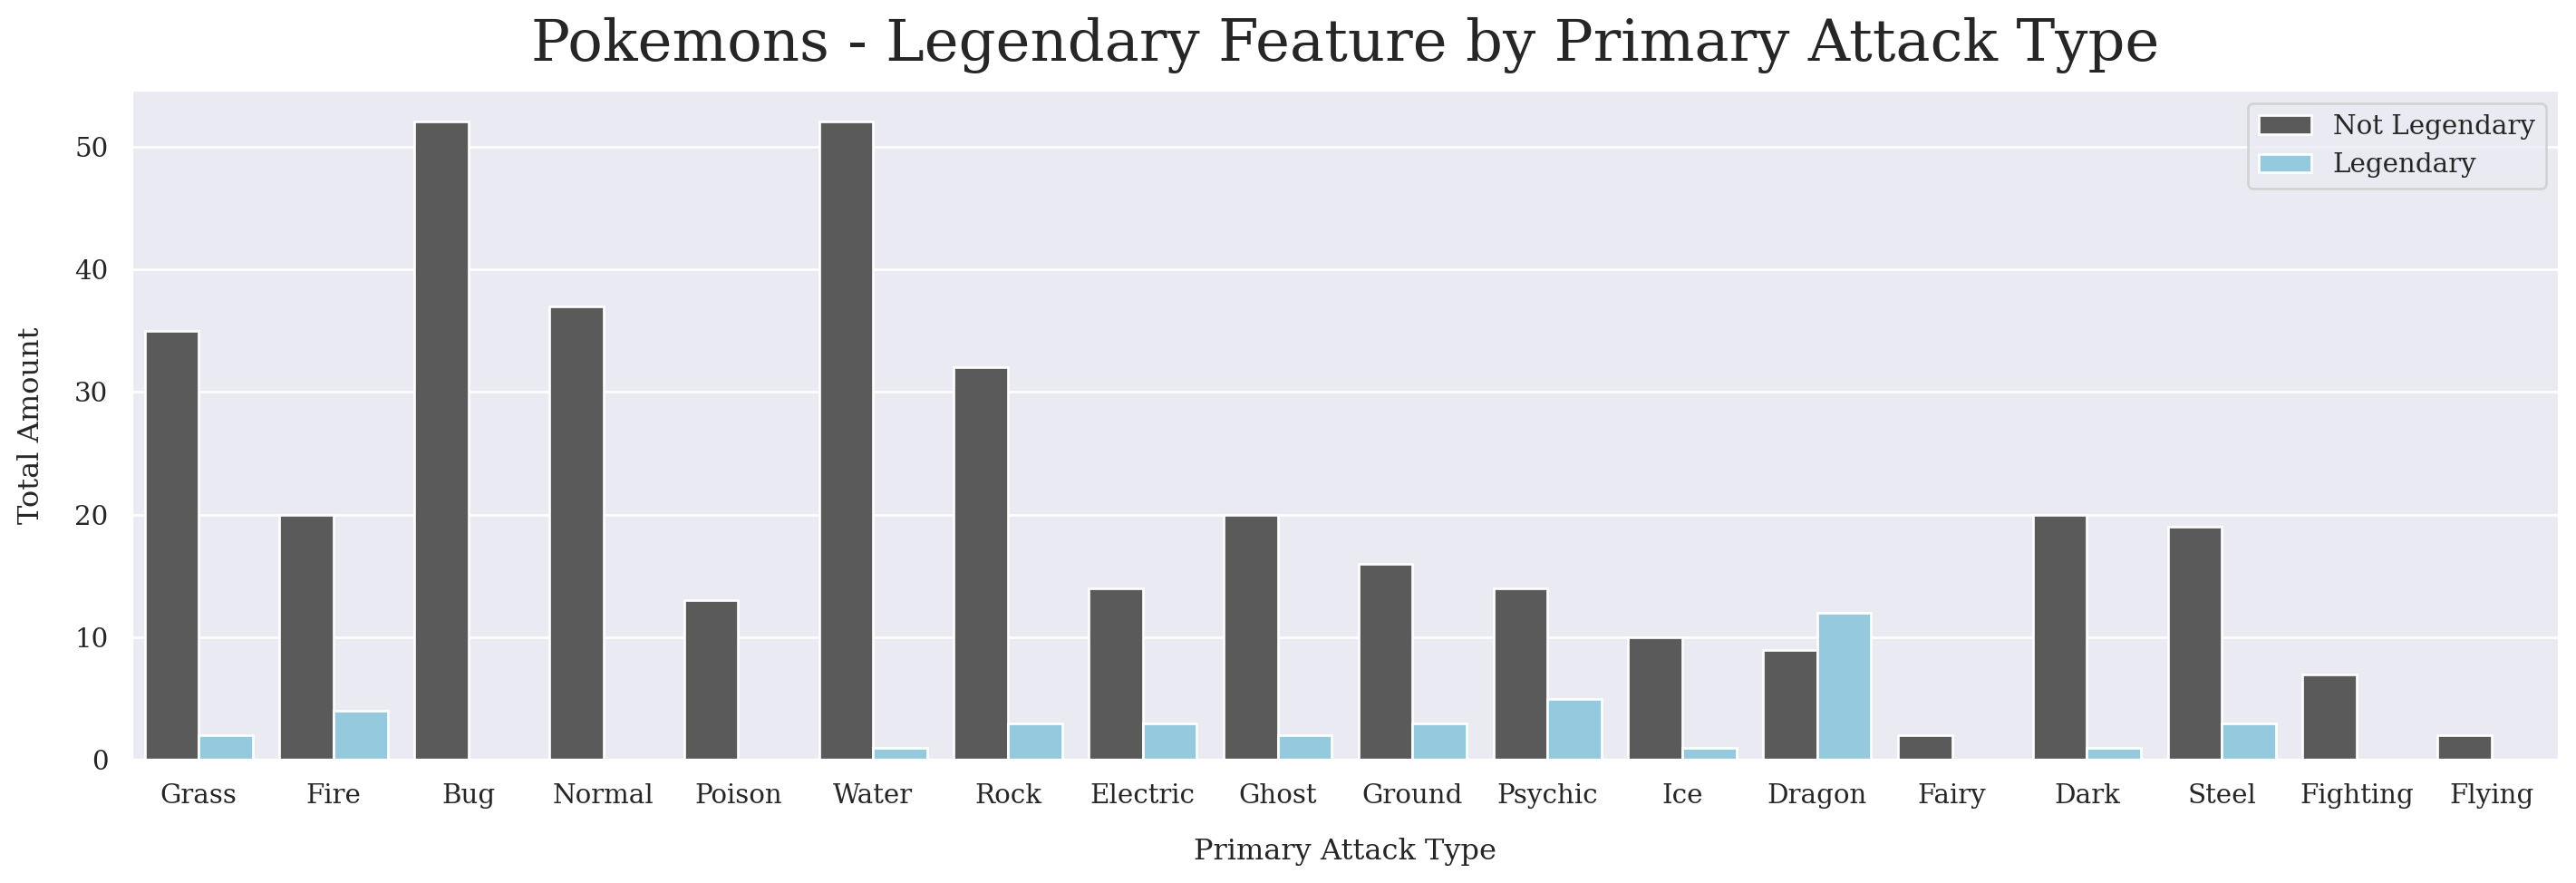

In [17]:
plt.figure(figsize=(18,5), dpi=192);
ax = sns.countplot(data=df_vis, x="Type 1", hue="Legendary")
plt.xlabel("Primary Attack Type", labelpad=12)
plt.ylabel("Total Amount", labelpad=12)
plt.legend(labels=["Not Legendary", "Legendary"], loc="upper right")
plt.title("Pokemons - Legendary Feature by Primary Attack Type", fontdict={"fontsize": 24}, pad=12);

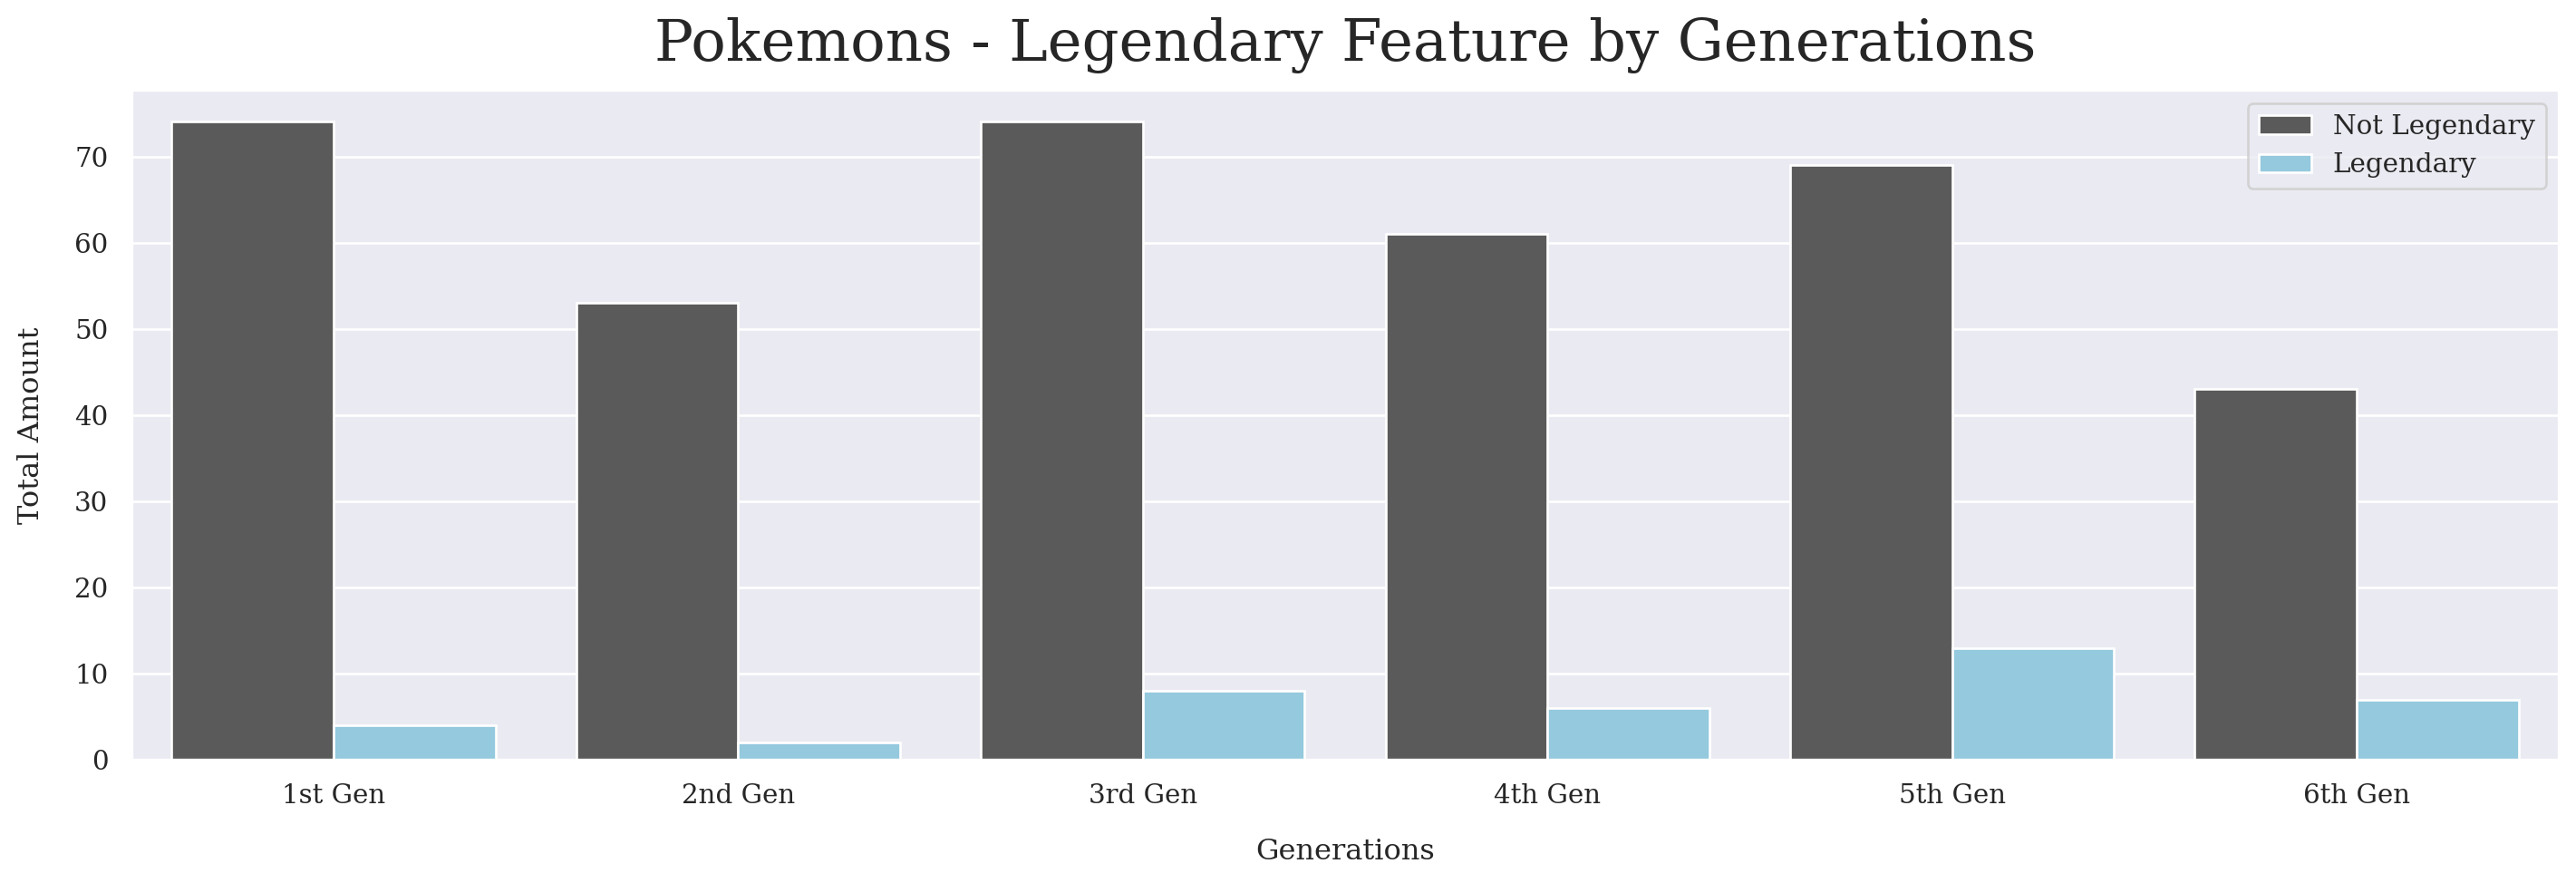

In [18]:
plt.figure(figsize=(18,5), dpi=192);
ax = sns.countplot(data=df_vis, x="Generation", hue="Legendary")
ax.set_xticklabels(["1st Gen", "2nd Gen", "3rd Gen", "4th Gen", "5th Gen", "6th Gen"])
plt.xlabel("Generations", labelpad=12)
plt.ylabel("Total Amount", labelpad=12)
plt.legend(labels=["Not Legendary", "Legendary"], loc="upper right")
plt.title("Pokemons - Legendary Feature by Generations", fontdict={"fontsize": 24}, pad=12);

### **_Pie Charts_**

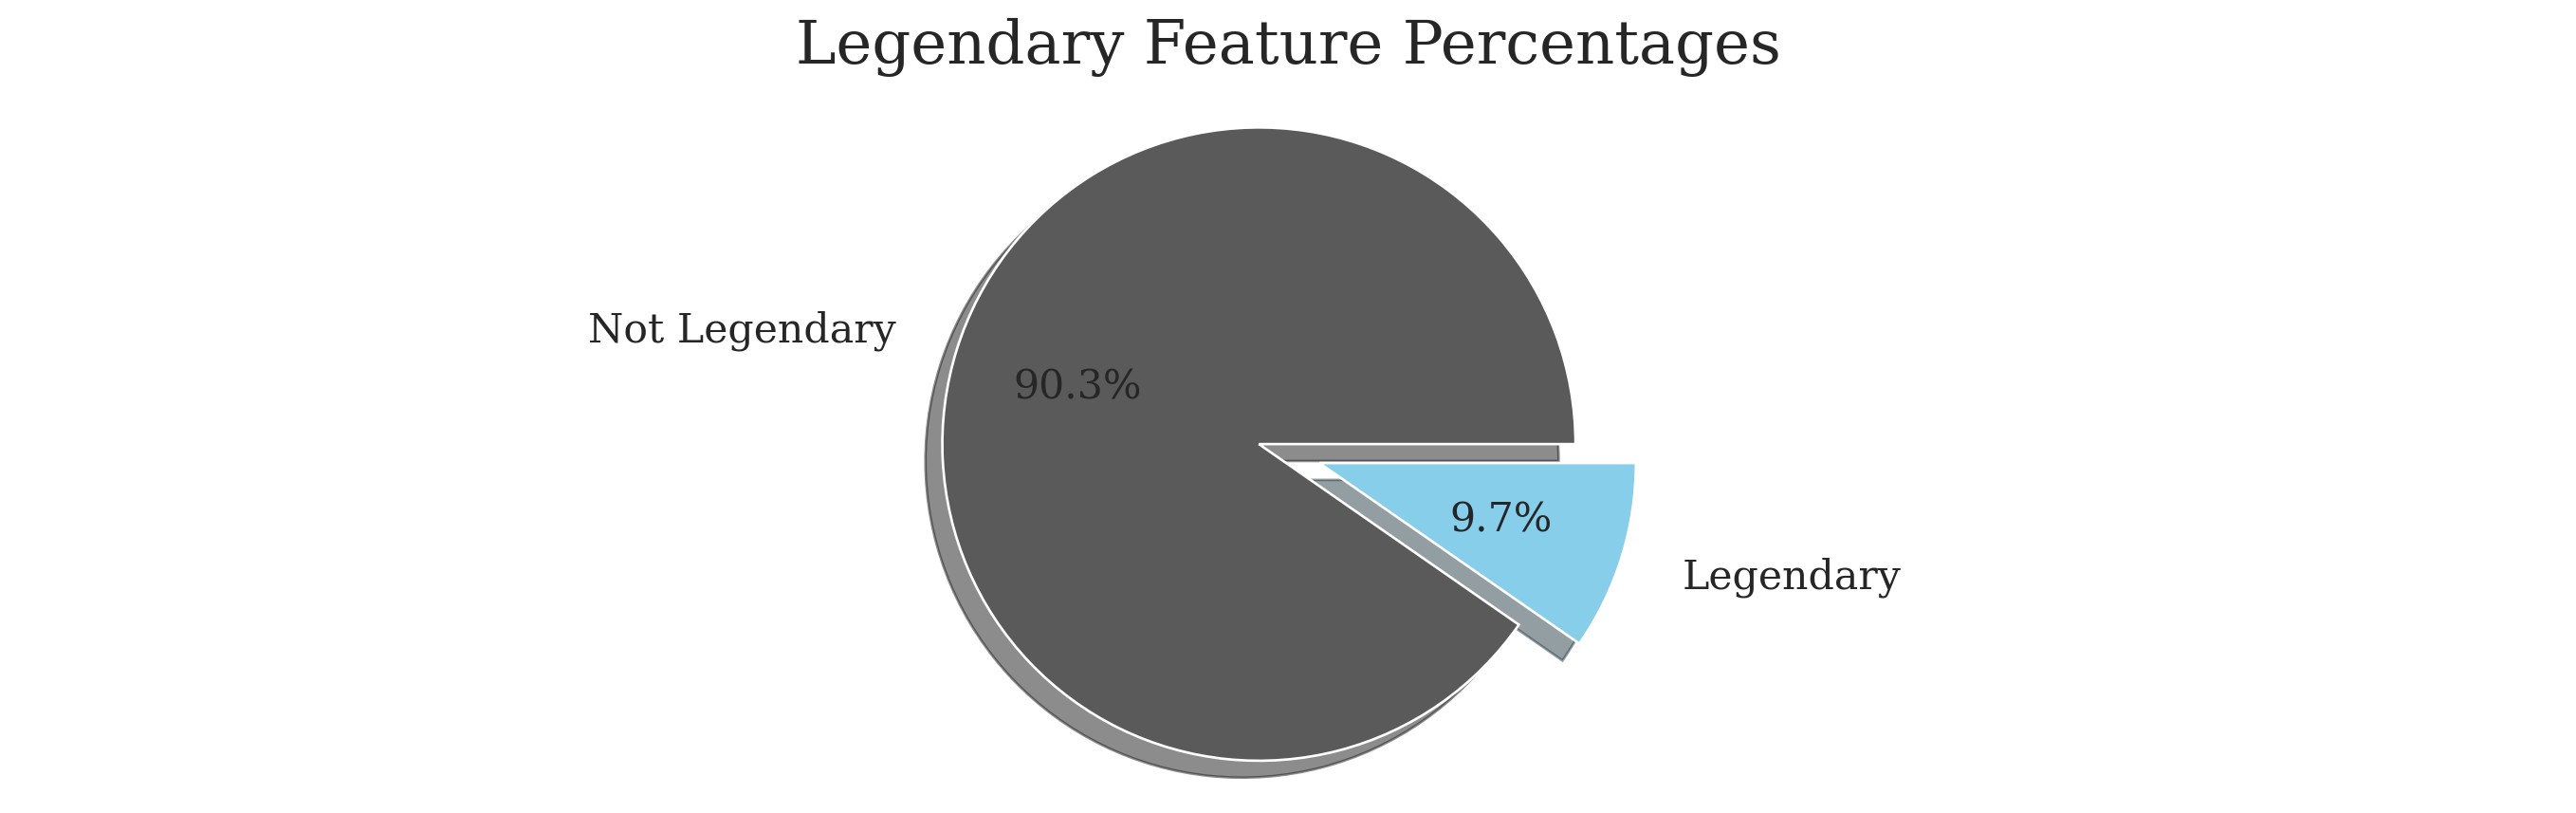

In [19]:
leg_labels = ["Not Legendary", "Legendary"]
leg_explode = [0.2, 0]
leg_title = "Legendary Feature Percentages"
pie_chart("Legendary", df_vis, title=leg_title, labels=leg_labels, explode=leg_explode, pad=12, shadow=True)

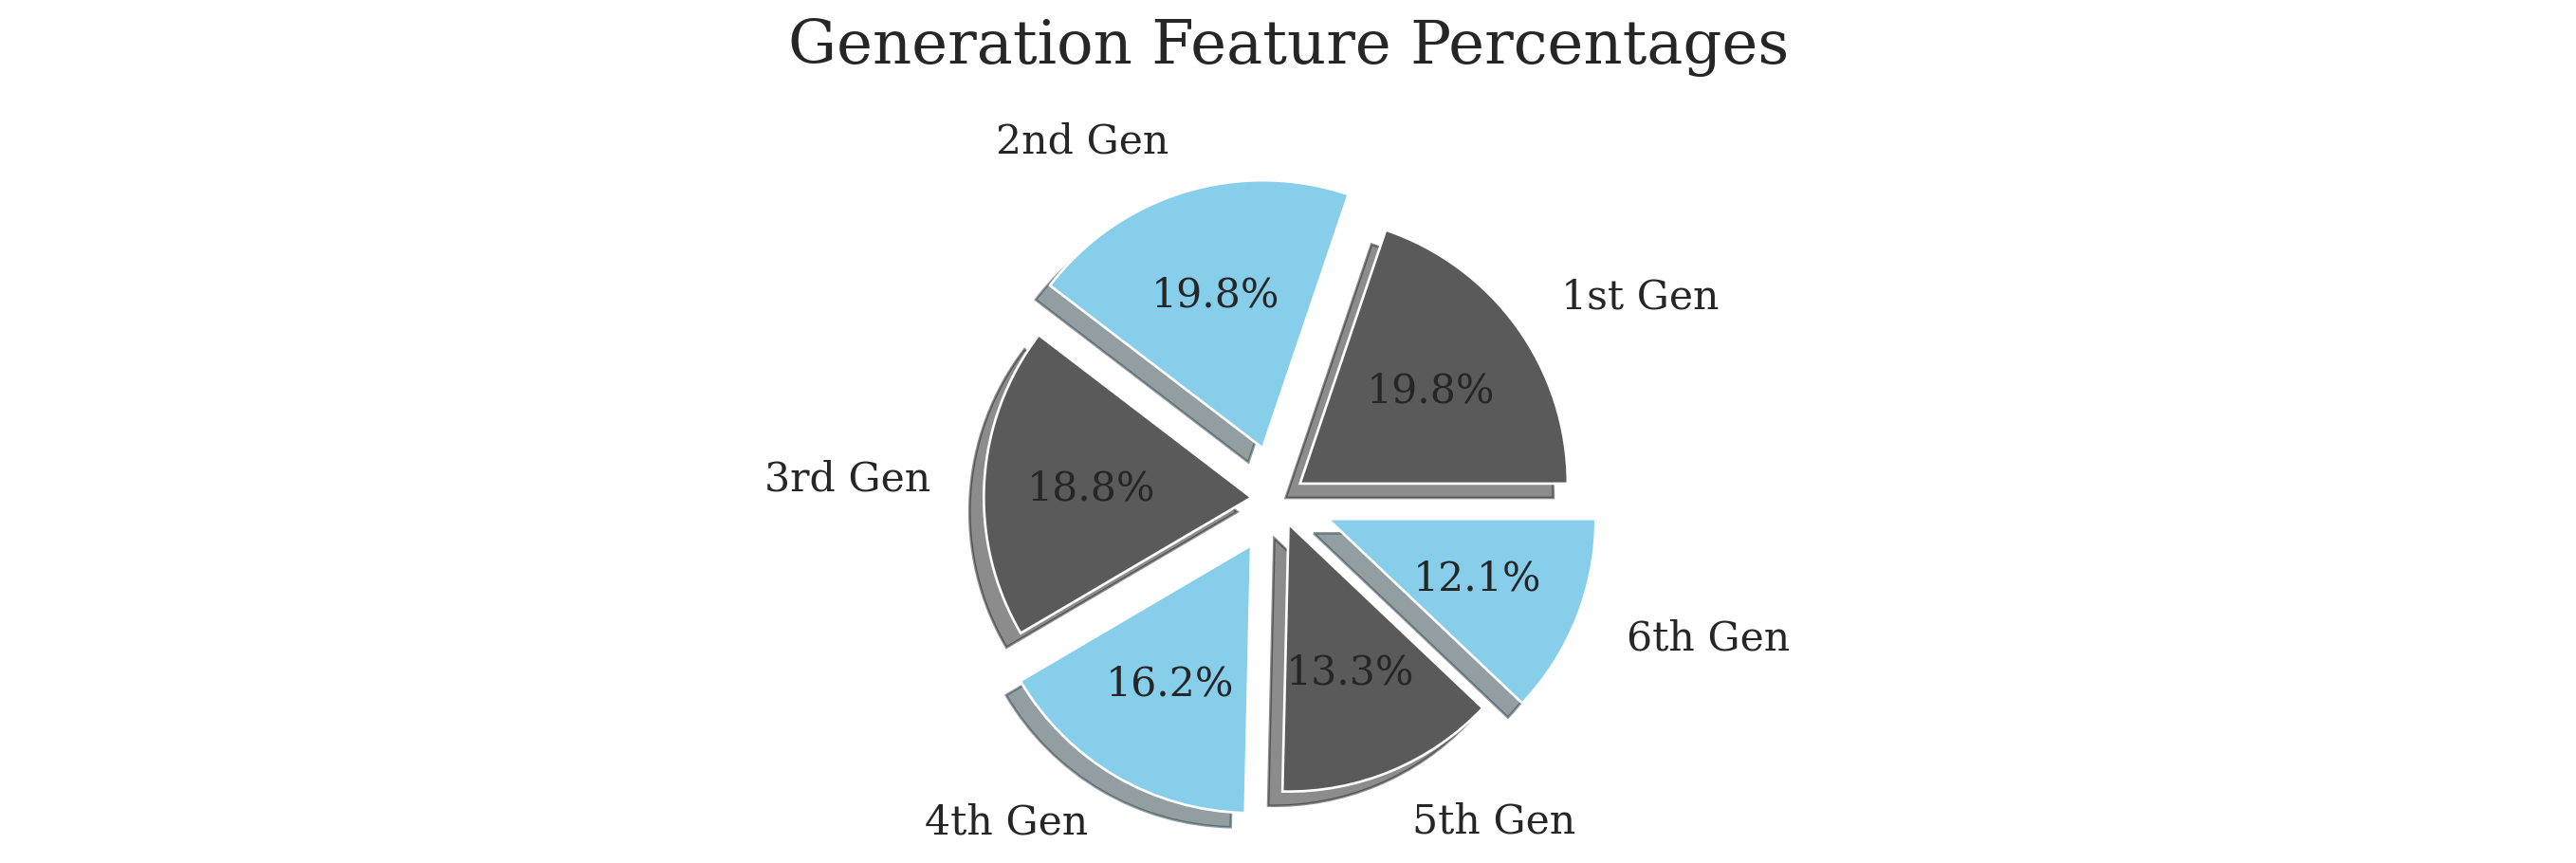

In [20]:
gen_labels = ["1st Gen", "2nd Gen", "3rd Gen", "4th Gen", "5th Gen", "6th Gen"]
gen_explode = [0.1, 0.2, 0.1, 0.2, 0.1, 0.2]
gen_title = "Generation Feature Percentages"
pie_chart("Generation", df_vis, title=gen_title, labels=gen_labels, explode=gen_explode, pad=32, shadow=True)

### **_Doughnut Charts_**

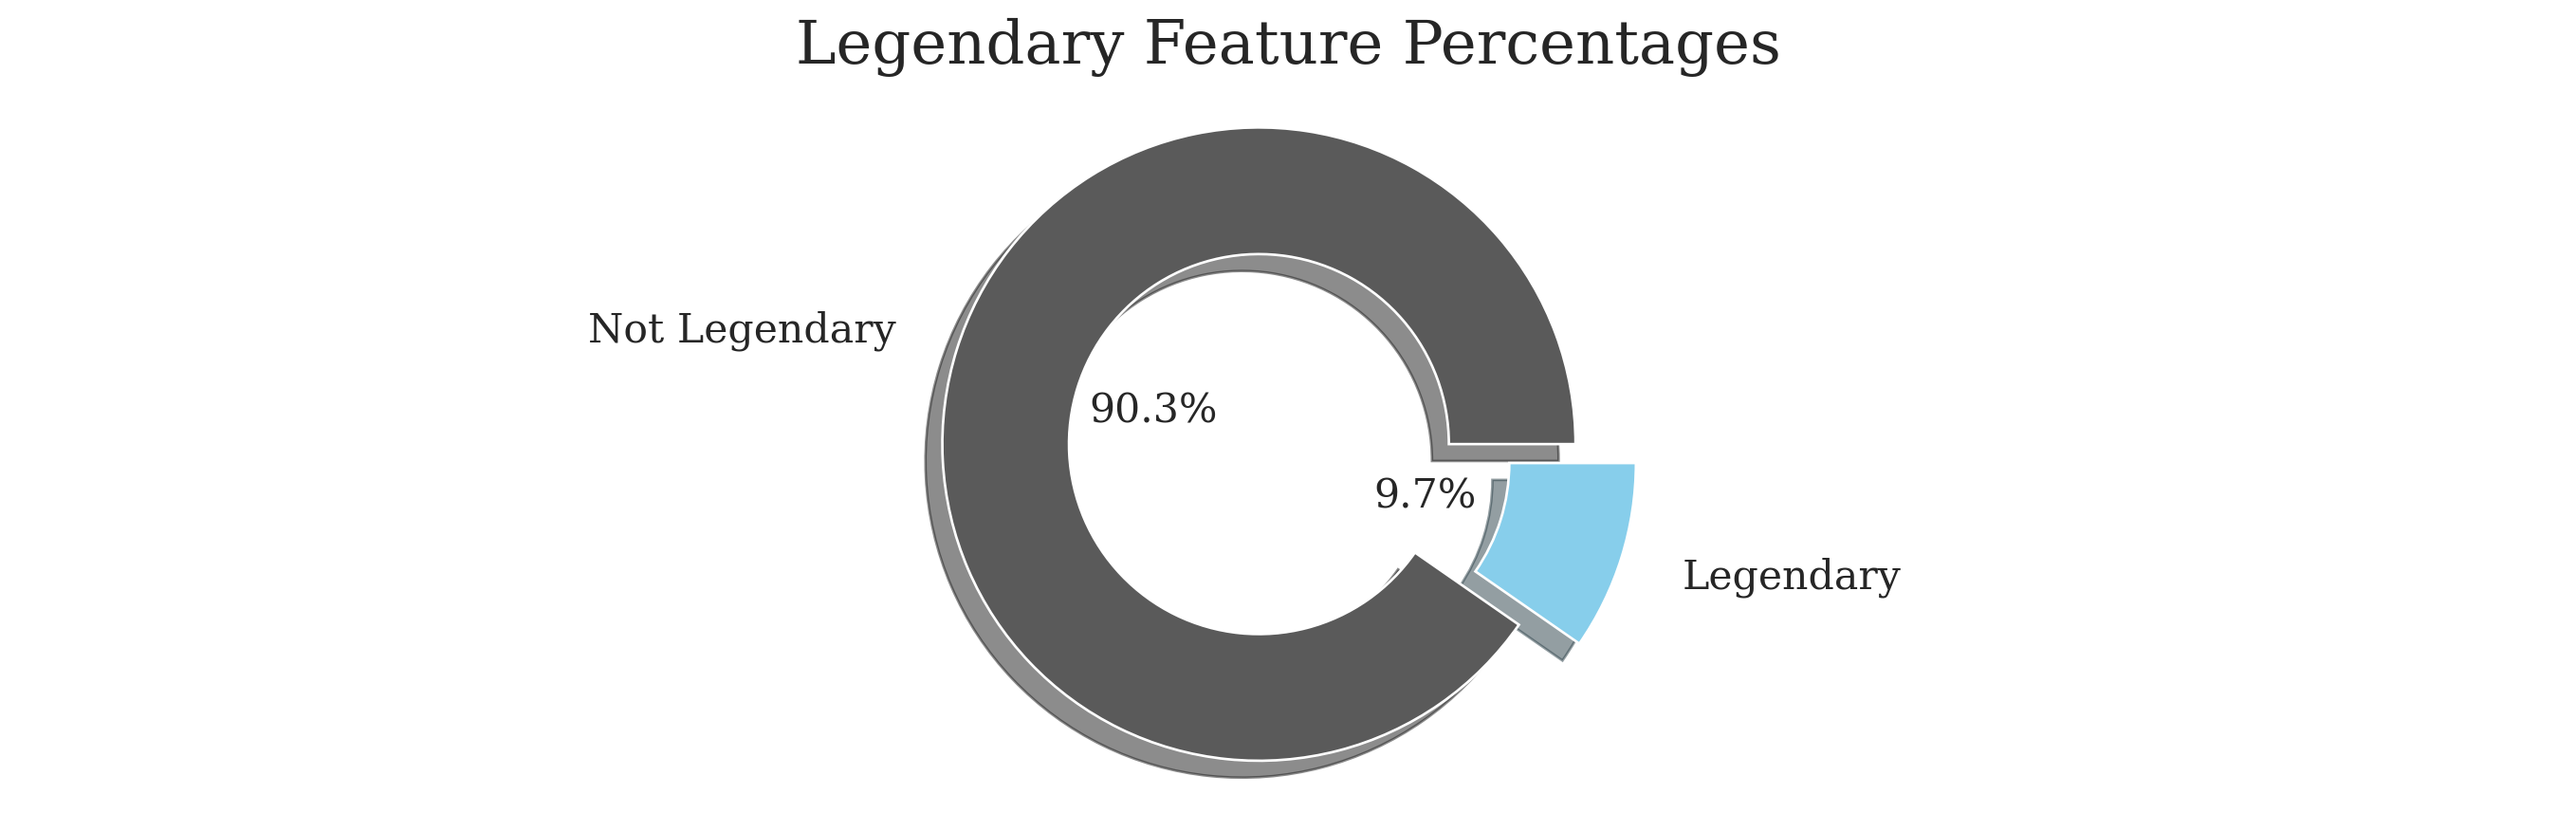

In [21]:
leg_labels = ["Not Legendary", "Legendary"]
leg_explode = [0.2, 0]
leg_title = "Legendary Feature Percentages"
doughnut_chart("Legendary", df_vis, title=leg_title, labels=leg_labels, explode=leg_explode, pad=12, shadow=True)

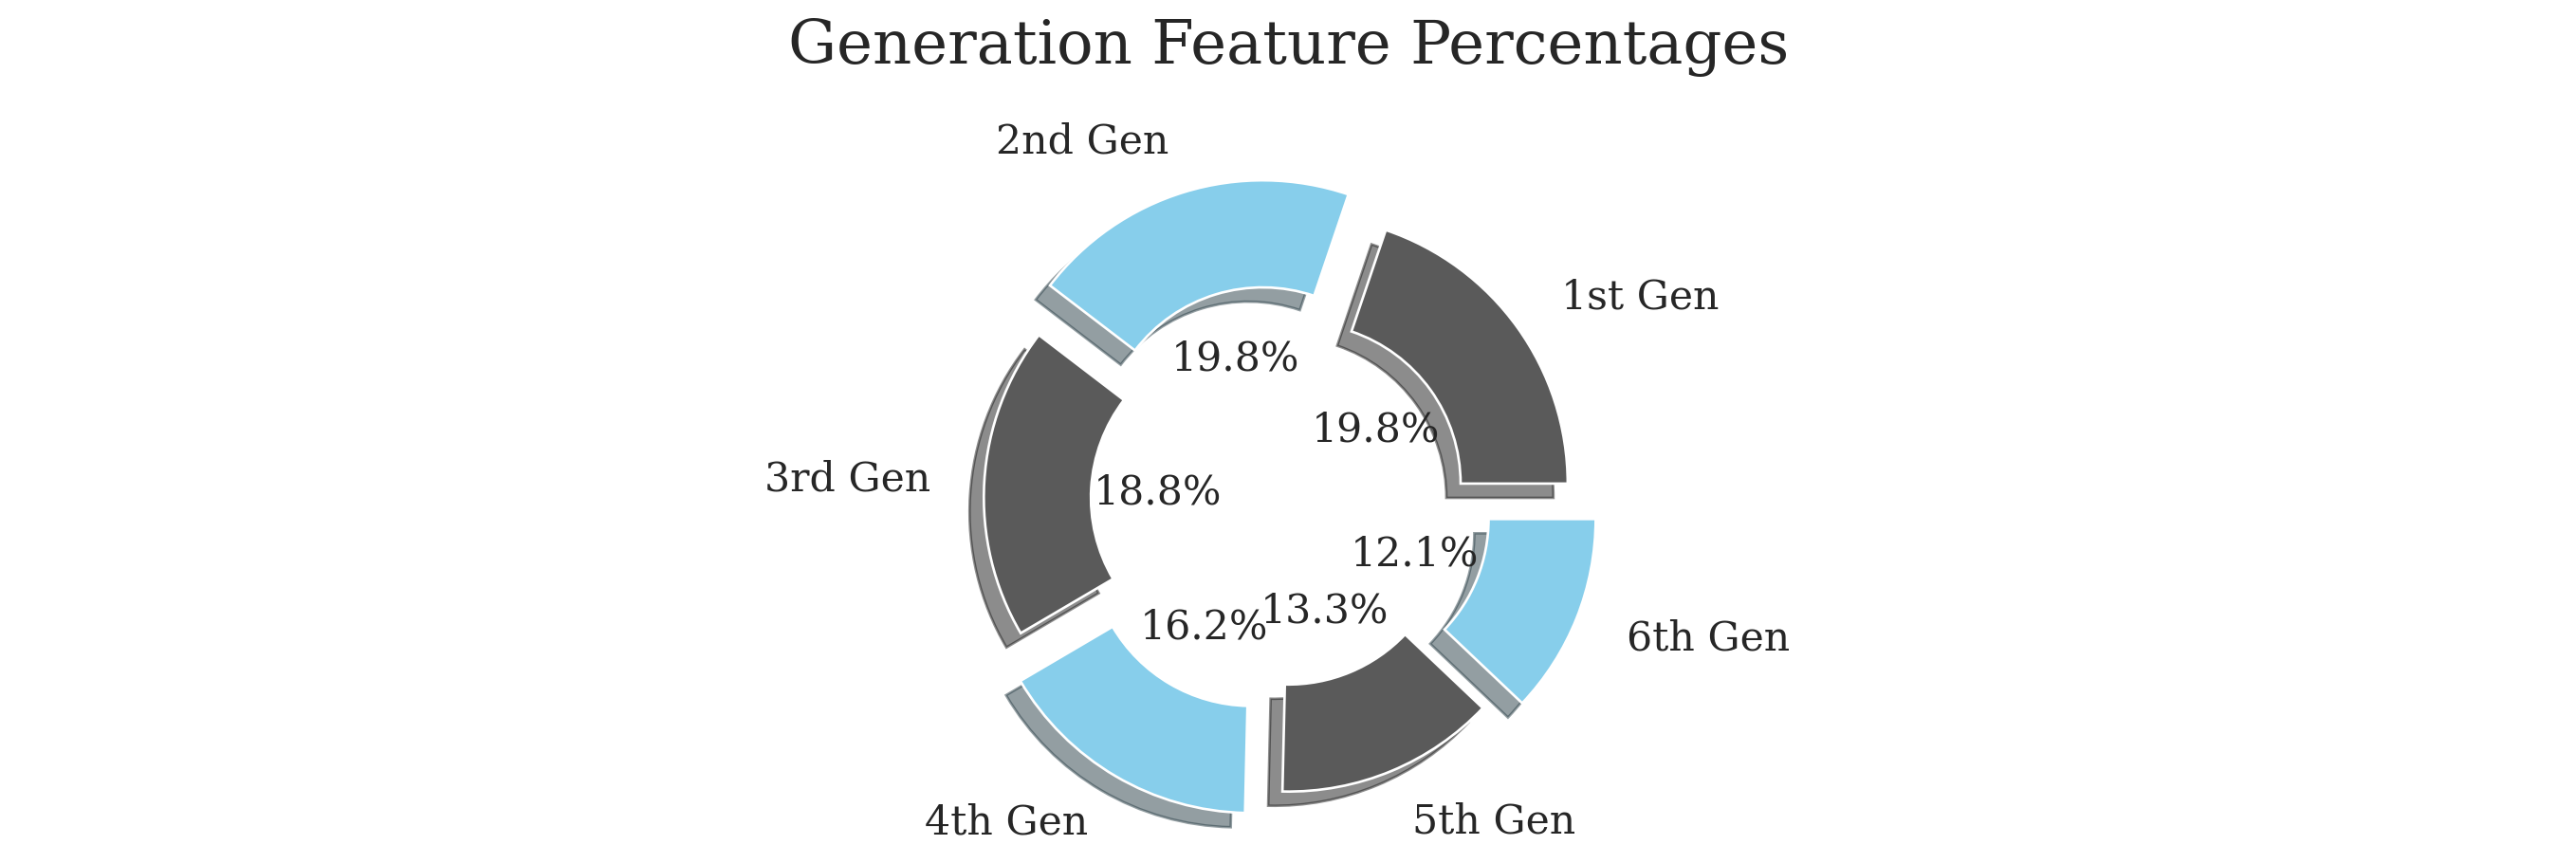

In [22]:
gen_labels = ["1st Gen", "2nd Gen", "3rd Gen", "4th Gen", "5th Gen", "6th Gen"]
gen_explode = [0.1, 0.2, 0.1, 0.2, 0.1, 0.2]
gen_title = "Generation Feature Percentages"
doughnut_chart("Generation", df_vis, title=gen_title, labels=gen_labels, explode=gen_explode, pad=32, shadow=True)

### **_Stacked Bar Charts_**

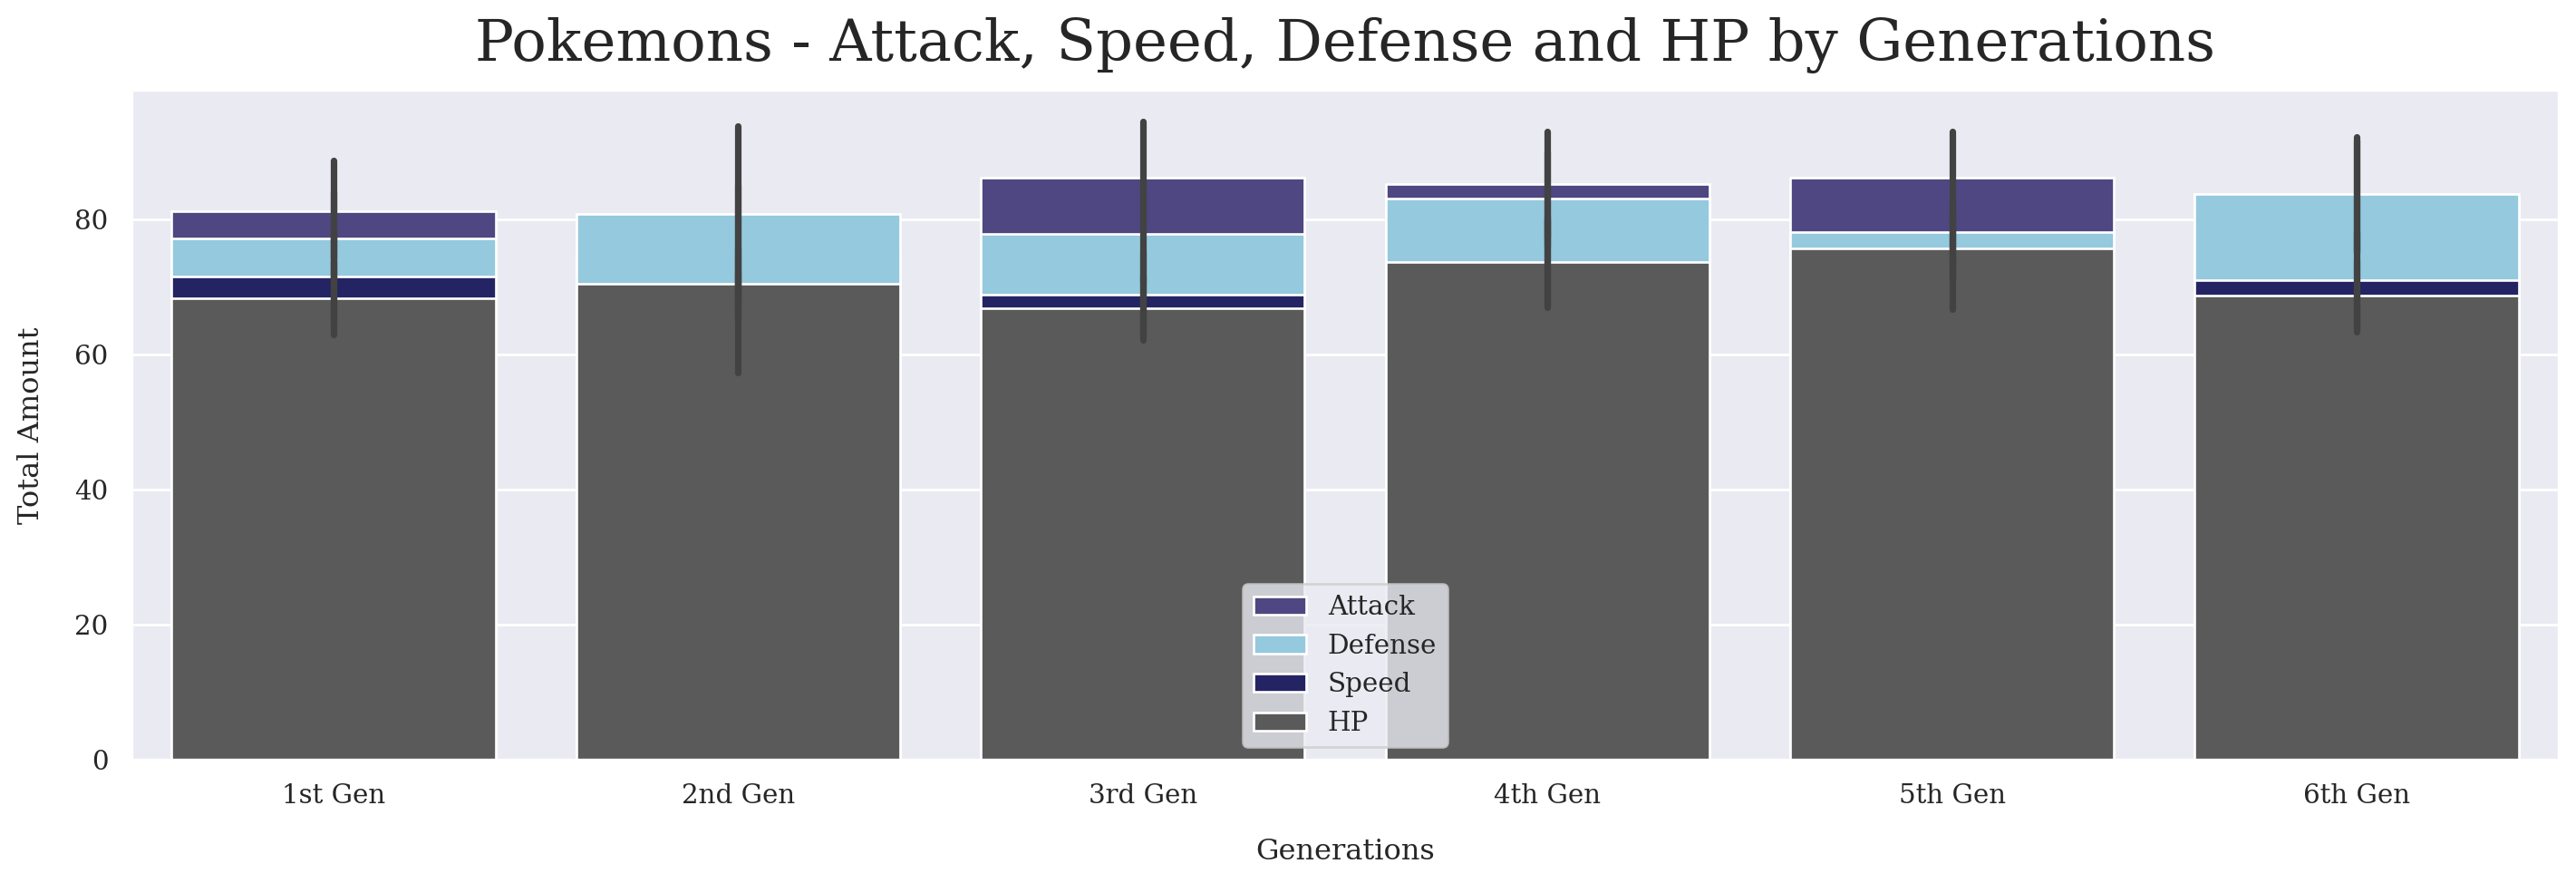

In [23]:
plt.figure(figsize=(18, 5), dpi=192)
ax = sns.barplot(x="Generation", y="Attack", data=df_vis, label="Attack", color="darkslateblue");
ax = sns.barplot(x="Generation", y="Defense", data=df_vis, label="Defense", palette=["#87CEEB"]);
ax = sns.barplot(x="Generation", y="Speed", data=df_vis, label="Speed", color="midnightblue");
ax = sns.barplot(x="Generation", y="HP", data=df_vis, label="HP", palette=["#5A5A5A"]);
ax.set_xticklabels(["1st Gen", "2nd Gen", "3rd Gen", "4th Gen", "5th Gen", "6th Gen"]);
plt.xlabel("Generations", labelpad=12)
plt.ylabel("Total Amount", labelpad=12)
plt.legend(loc="lower center")
plt.title("Pokemons - Attack, Speed, Defense and HP by Generations", fontdict={"fontsize": 24}, pad=12);

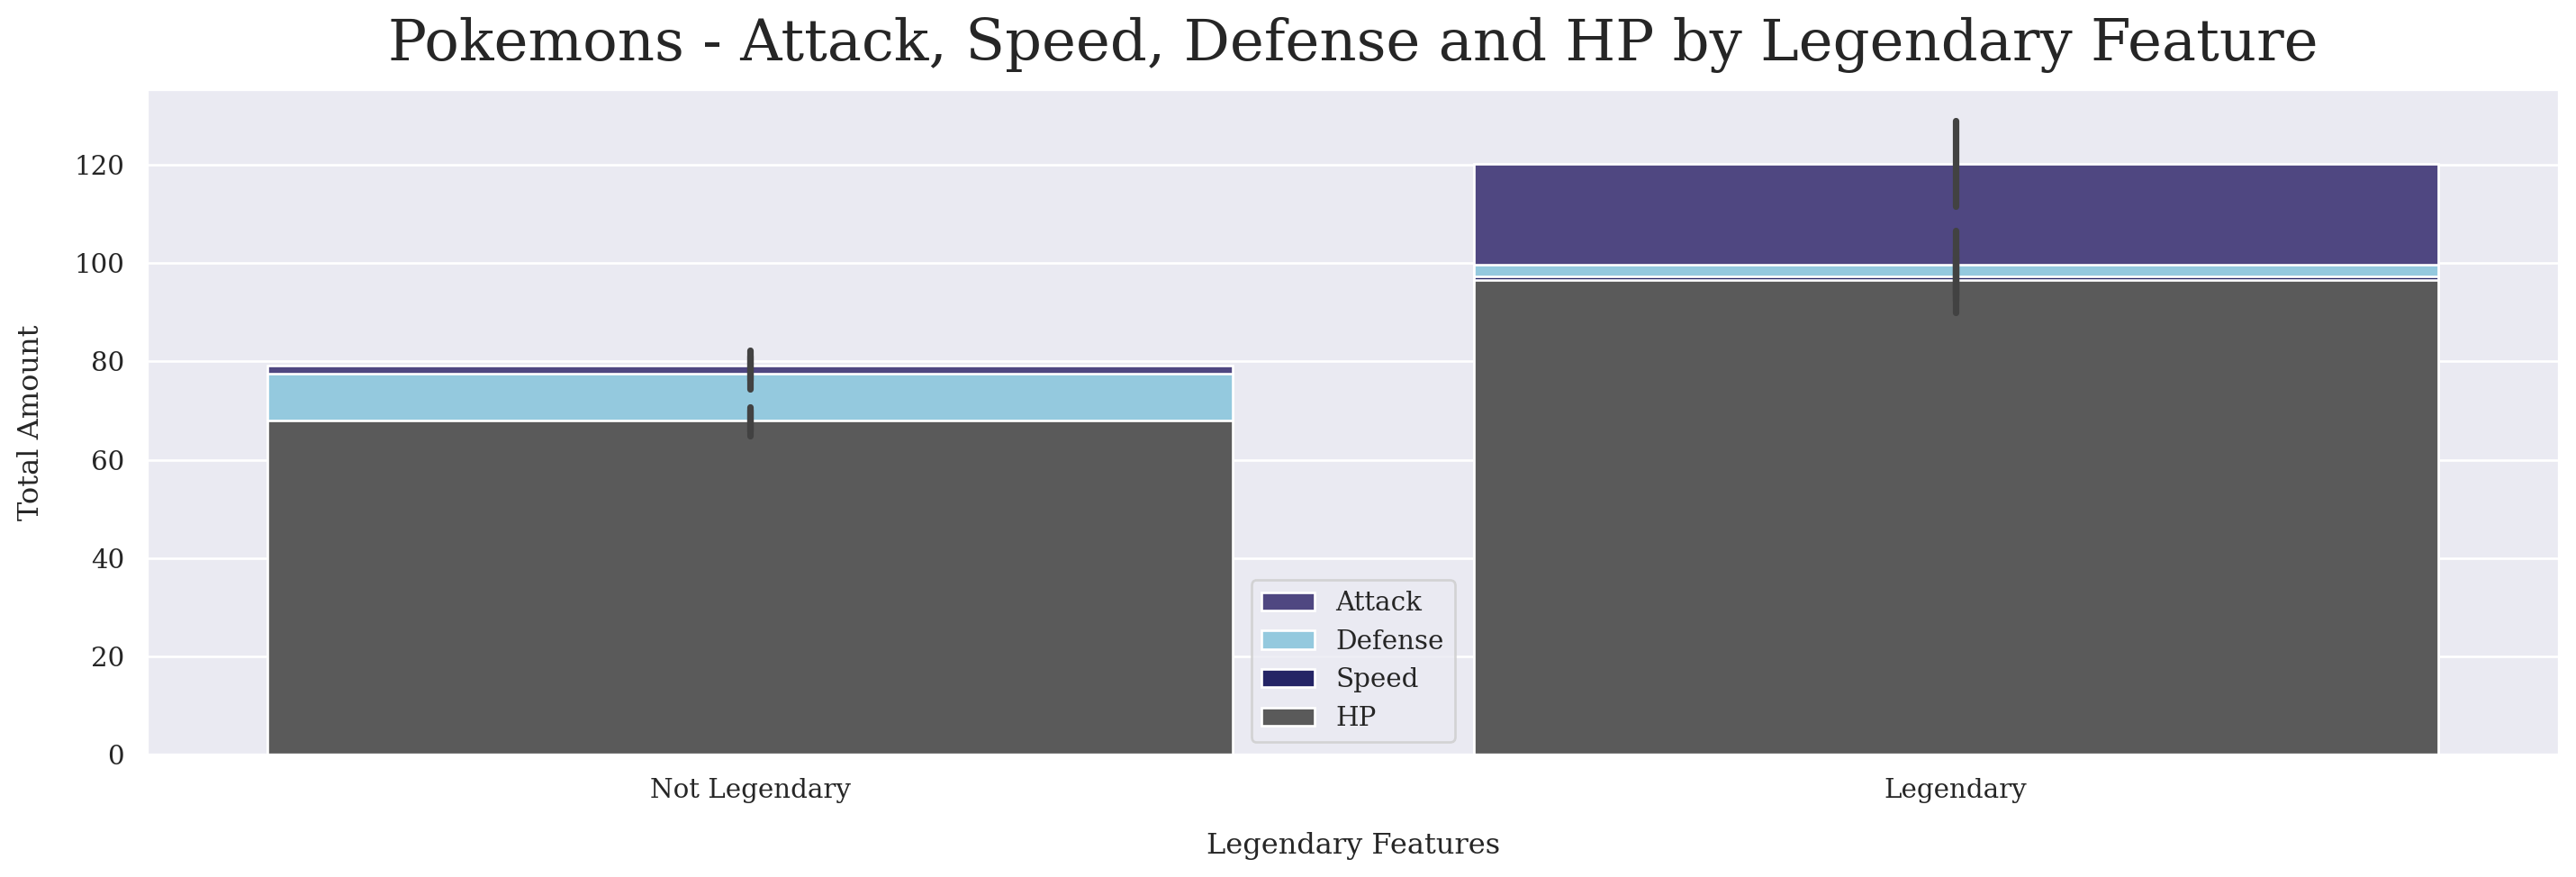

In [24]:
plt.figure(figsize=(18, 5), dpi=192)
ax = sns.barplot(x="Legendary", y="Attack", data=df_vis, label="Attack", color="darkslateblue");
ax = sns.barplot(x="Legendary", y="Defense", data=df_vis, label="Defense", palette=["#87CEEB"]);
ax = sns.barplot(x="Legendary", y="Speed", data=df_vis, label="Speed", color="midnightblue");
ax = sns.barplot(x="Legendary", y="HP", data=df_vis, label="HP", palette=["#5A5A5A"]);
ax.set_xticklabels(["Not Legendary", "Legendary"]);
plt.xlabel("Legendary Features", labelpad=12)
plt.ylabel("Total Amount", labelpad=12)
plt.legend(loc="lower center")
plt.title("Pokemons - Attack, Speed, Defense and HP by Legendary Feature", fontdict={"fontsize": 24}, pad=12);

### **_Violin Graphs_**

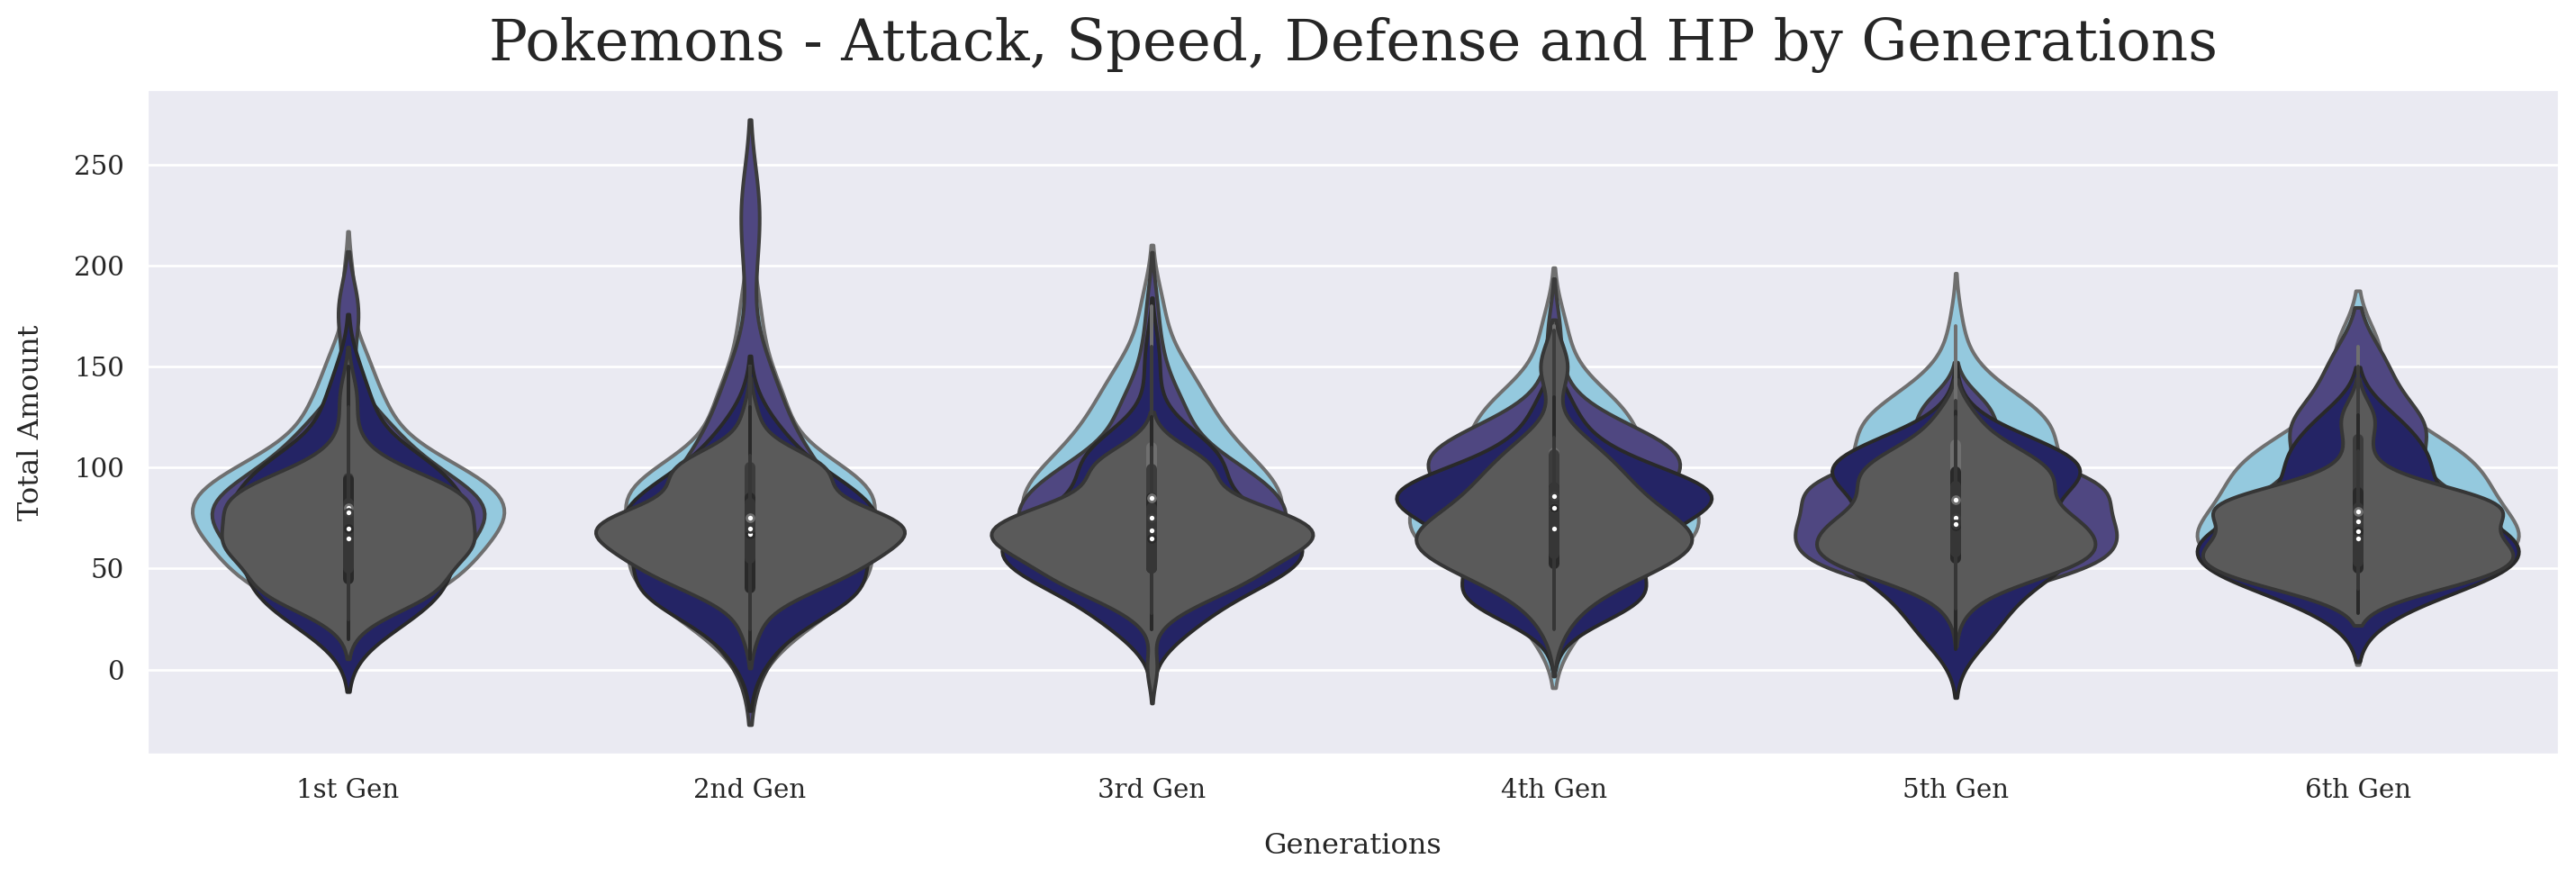

In [25]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.violinplot(x="Generation", y="Attack", data=df_vis, label="Attack", palette=["#87CEEB"]);
ax = sns.violinplot(x="Generation", y="Defense", data=df_vis, label="Defense", color="darkslateblue");
ax = sns.violinplot(x="Generation", y="Speed", data=df_vis, label="Speed", color="midnightblue");
ax = sns.violinplot(x="Generation", y="HP", data=df_vis, label="HP", palette=["#5A5A5A"]);
ax.set_xticklabels(["1st Gen", "2nd Gen", "3rd Gen", "4th Gen", "5th Gen", "6th Gen"]);
plt.xlabel("Generations", labelpad=12)
plt.ylabel("Total Amount", labelpad=12)
plt.title("Pokemons - Attack, Speed, Defense and HP by Generations", fontdict={"fontsize": 24}, pad=12);

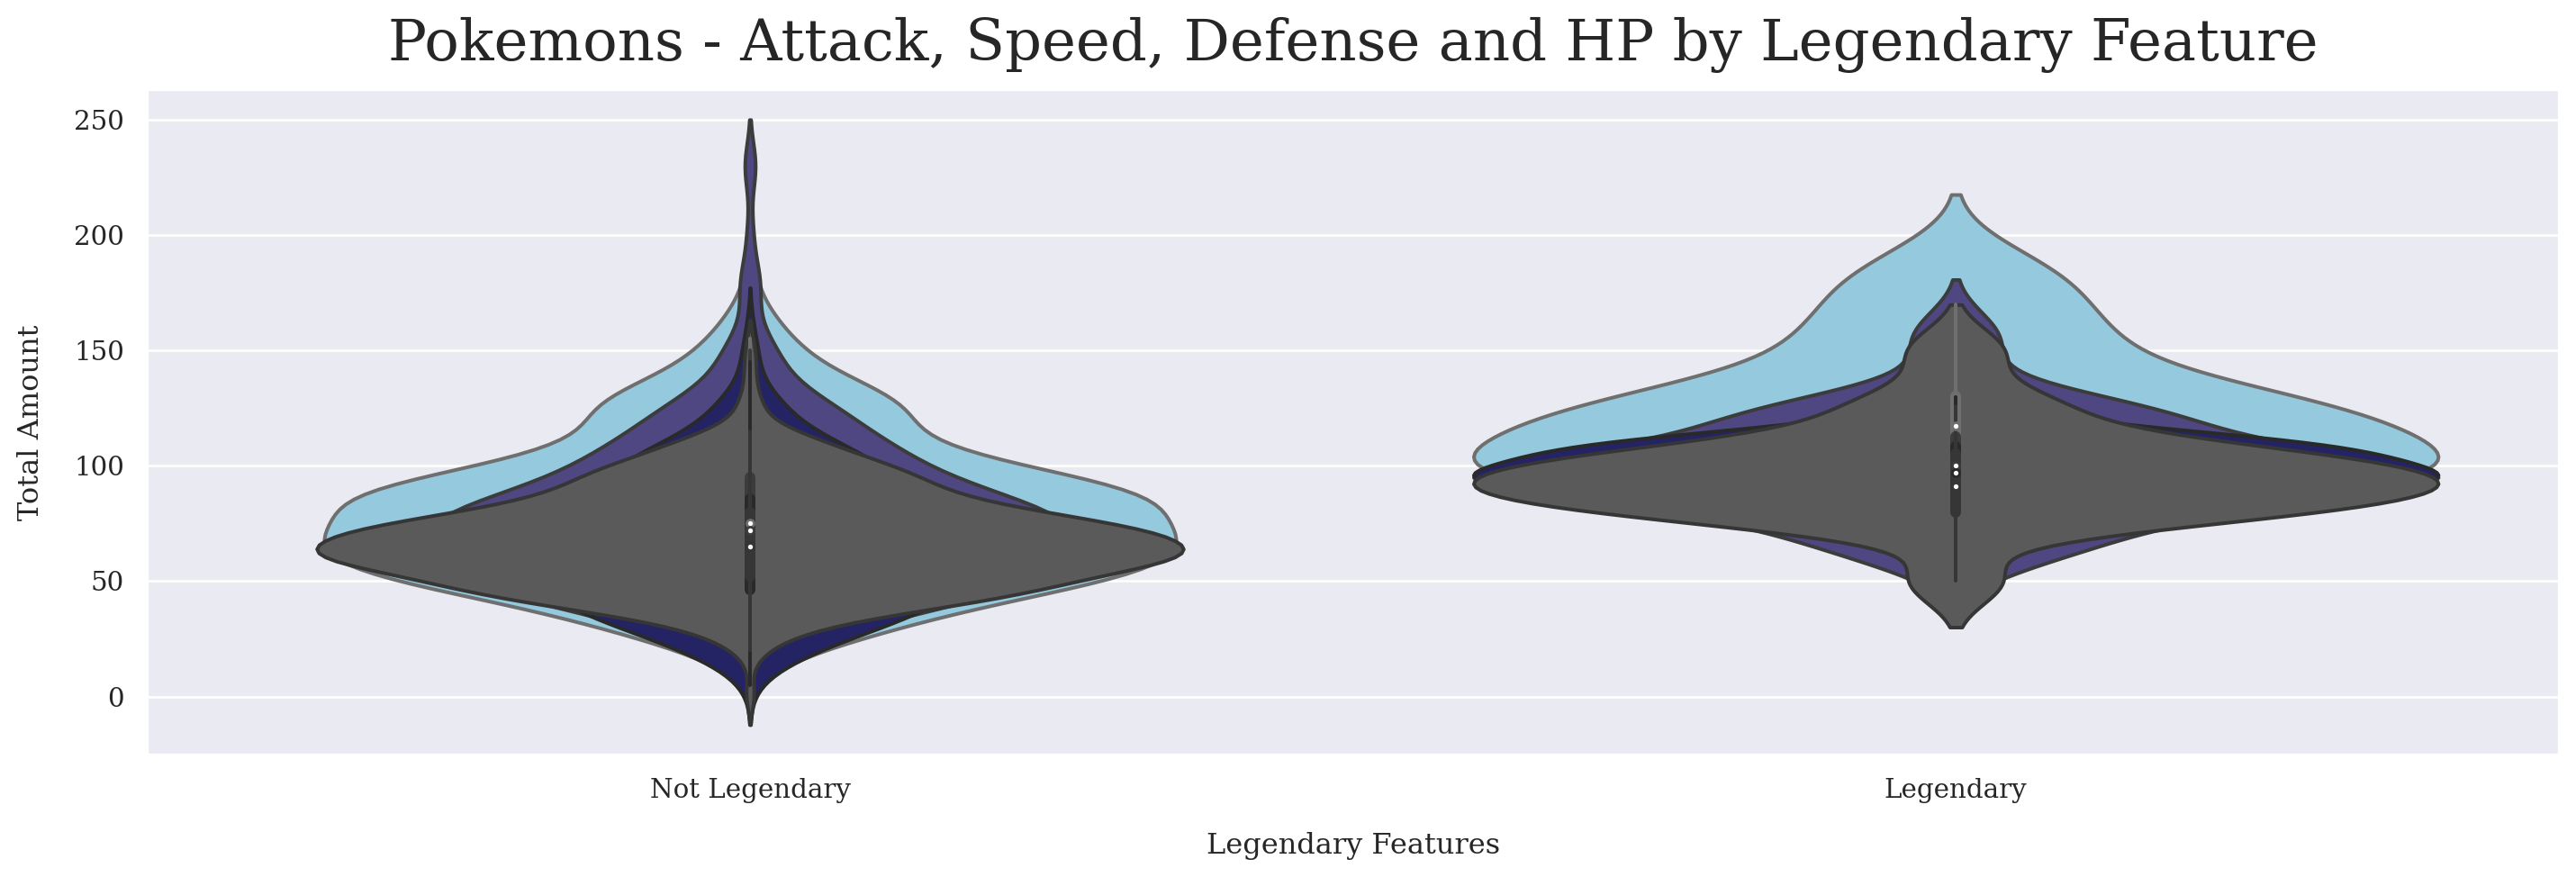

In [26]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.violinplot(x="Legendary", y="Attack", data=df_vis, palette=["#87CEEB"]);
ax = sns.violinplot(x="Legendary", y="Defense", data=df_vis, color="darkslateblue");
ax = sns.violinplot(x="Legendary", y="Speed", data=df_vis, color="midnightblue");
ax = sns.violinplot(x="Legendary", y="HP", data=df_vis,  palette=["#5A5A5A"]);
ax.set_xticklabels(["Not Legendary", "Legendary"]);
plt.xlabel("Legendary Features", labelpad=12)
plt.ylabel("Total Amount", labelpad=12)
plt.title("Pokemons - Attack, Speed, Defense and HP by Legendary Feature", fontdict={"fontsize": 24}, pad=12);

## **_Numerical Features_**

### **_Pairwise Graphs_**

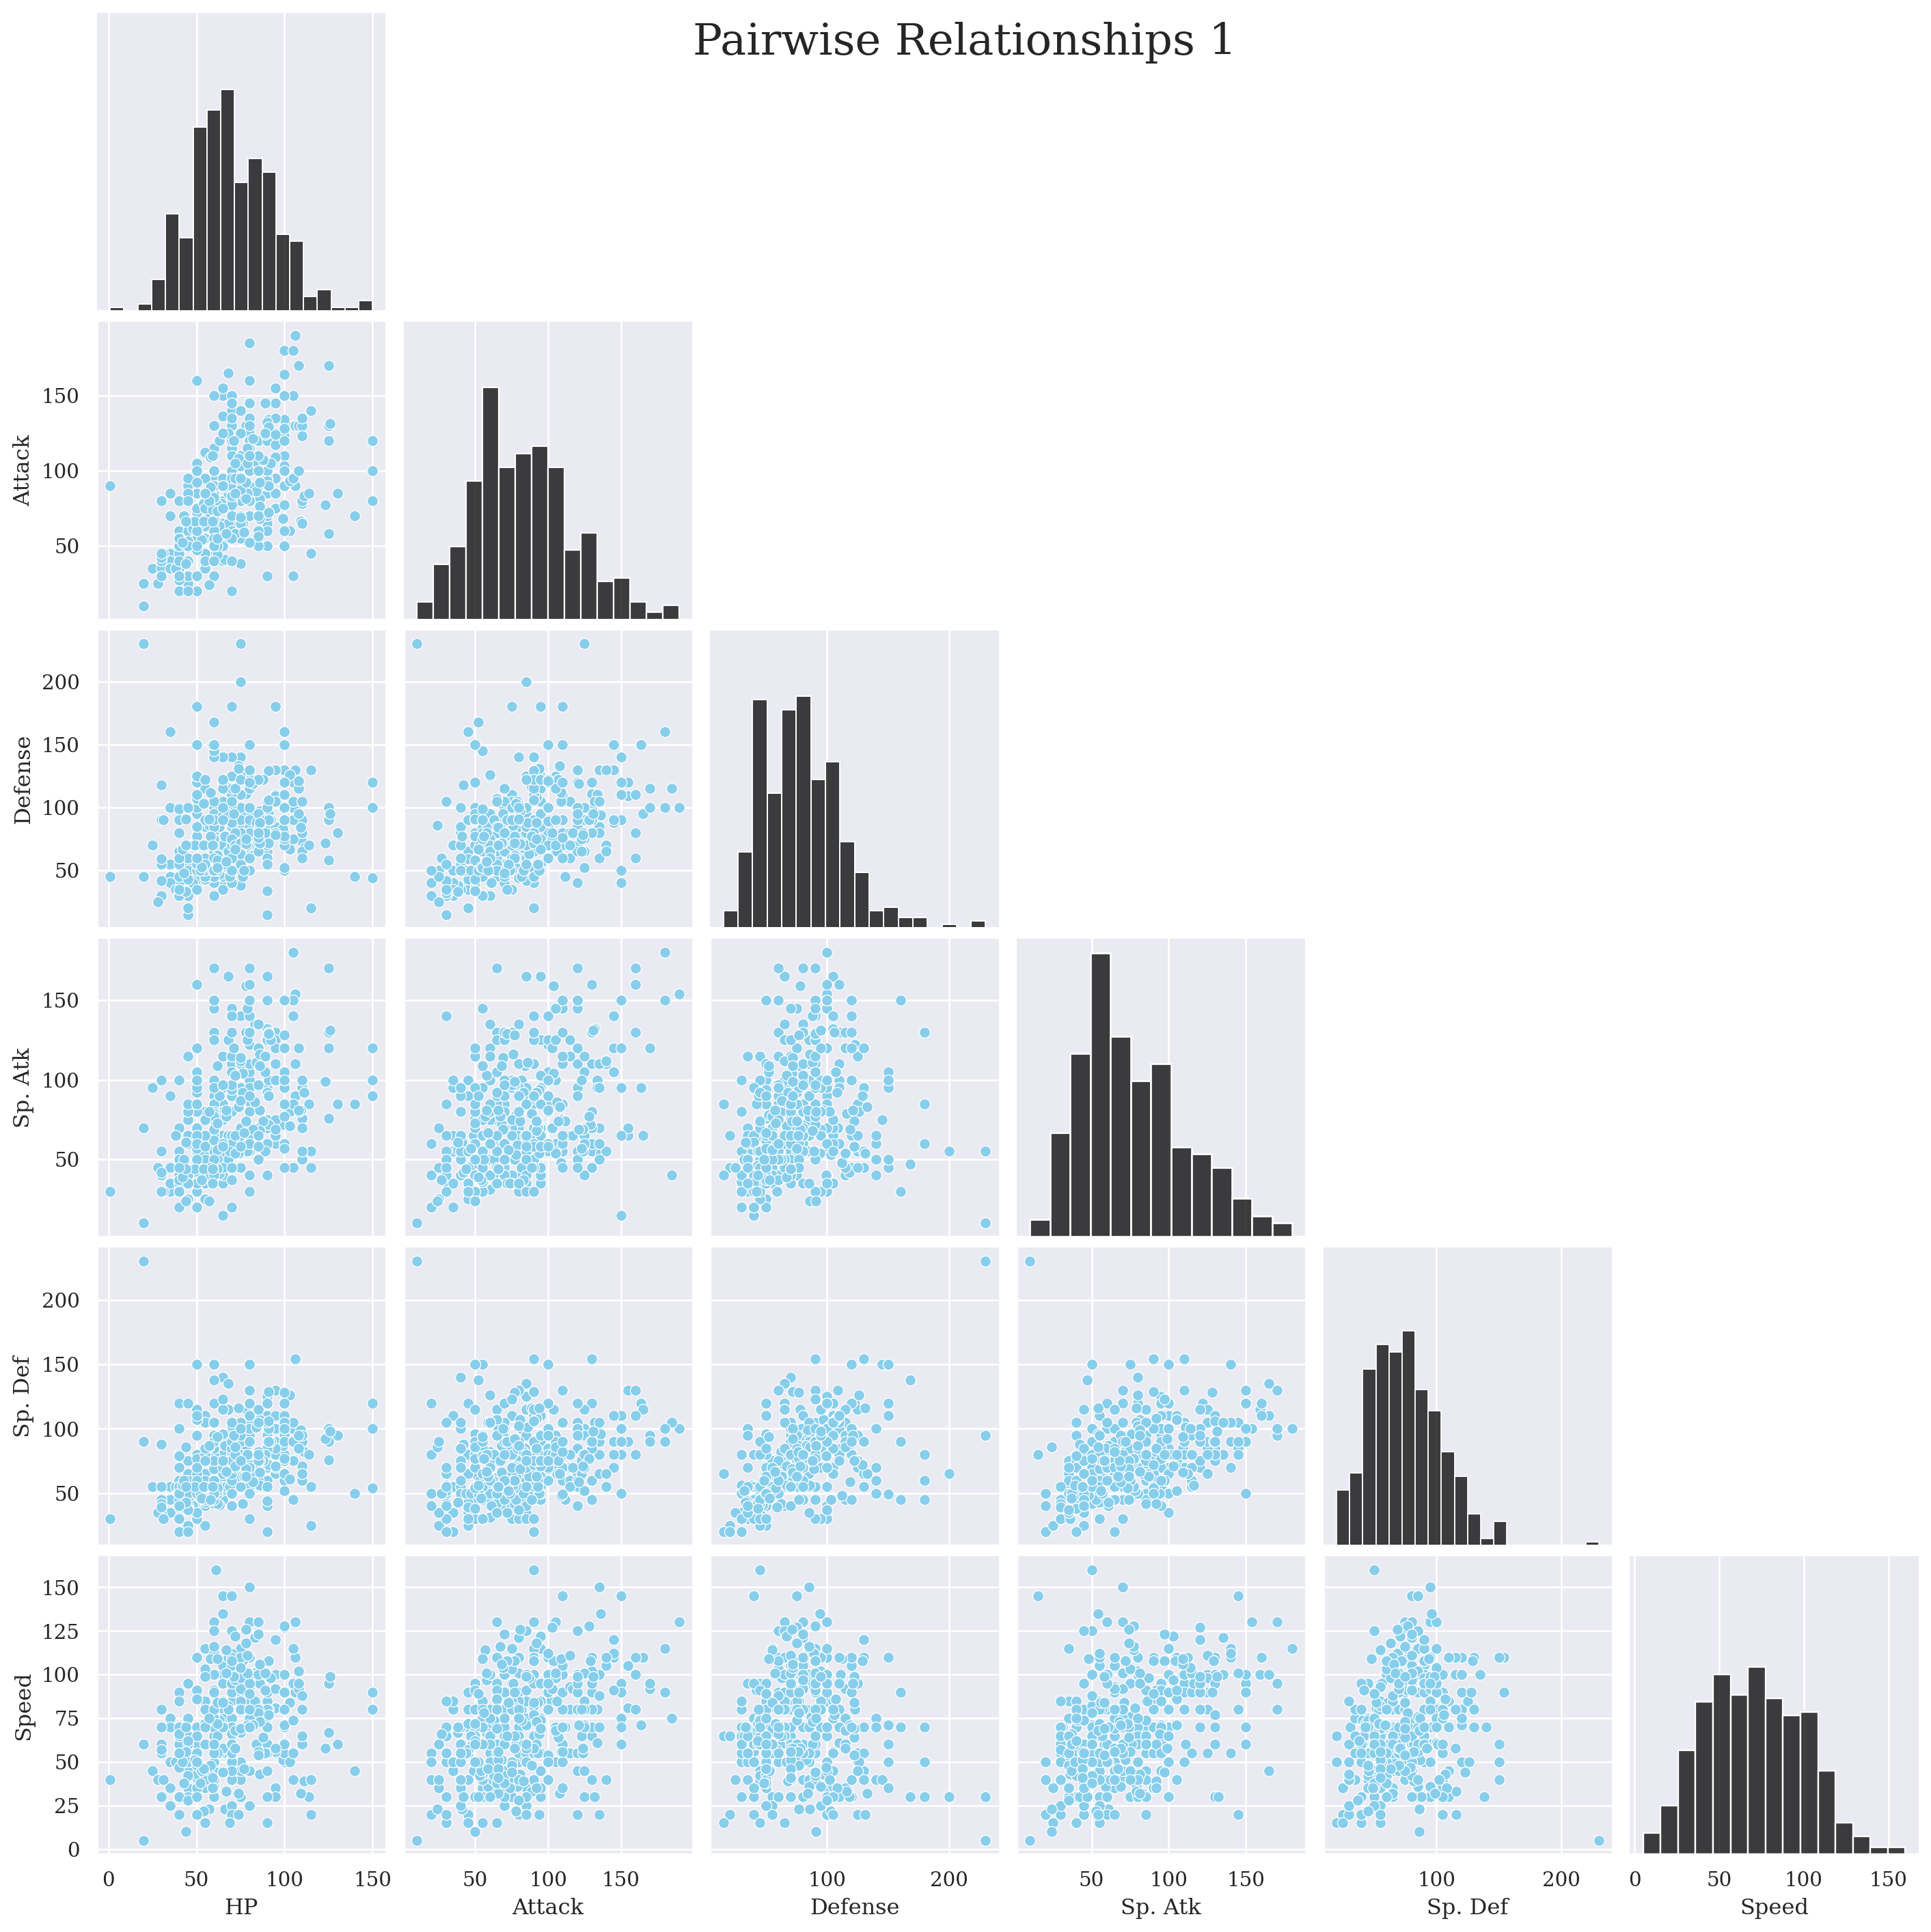

In [27]:
col = ["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]
g = sns.pairplot(df_vis.loc[:,col], corner=True, plot_kws={"color":"skyblue"}, diag_kws={"color":"black"})
g.fig.figsize = (18, 5)
g.fig.dpi = 192
g.fig.suptitle("Pairwise Relationships 1", fontsize=24);

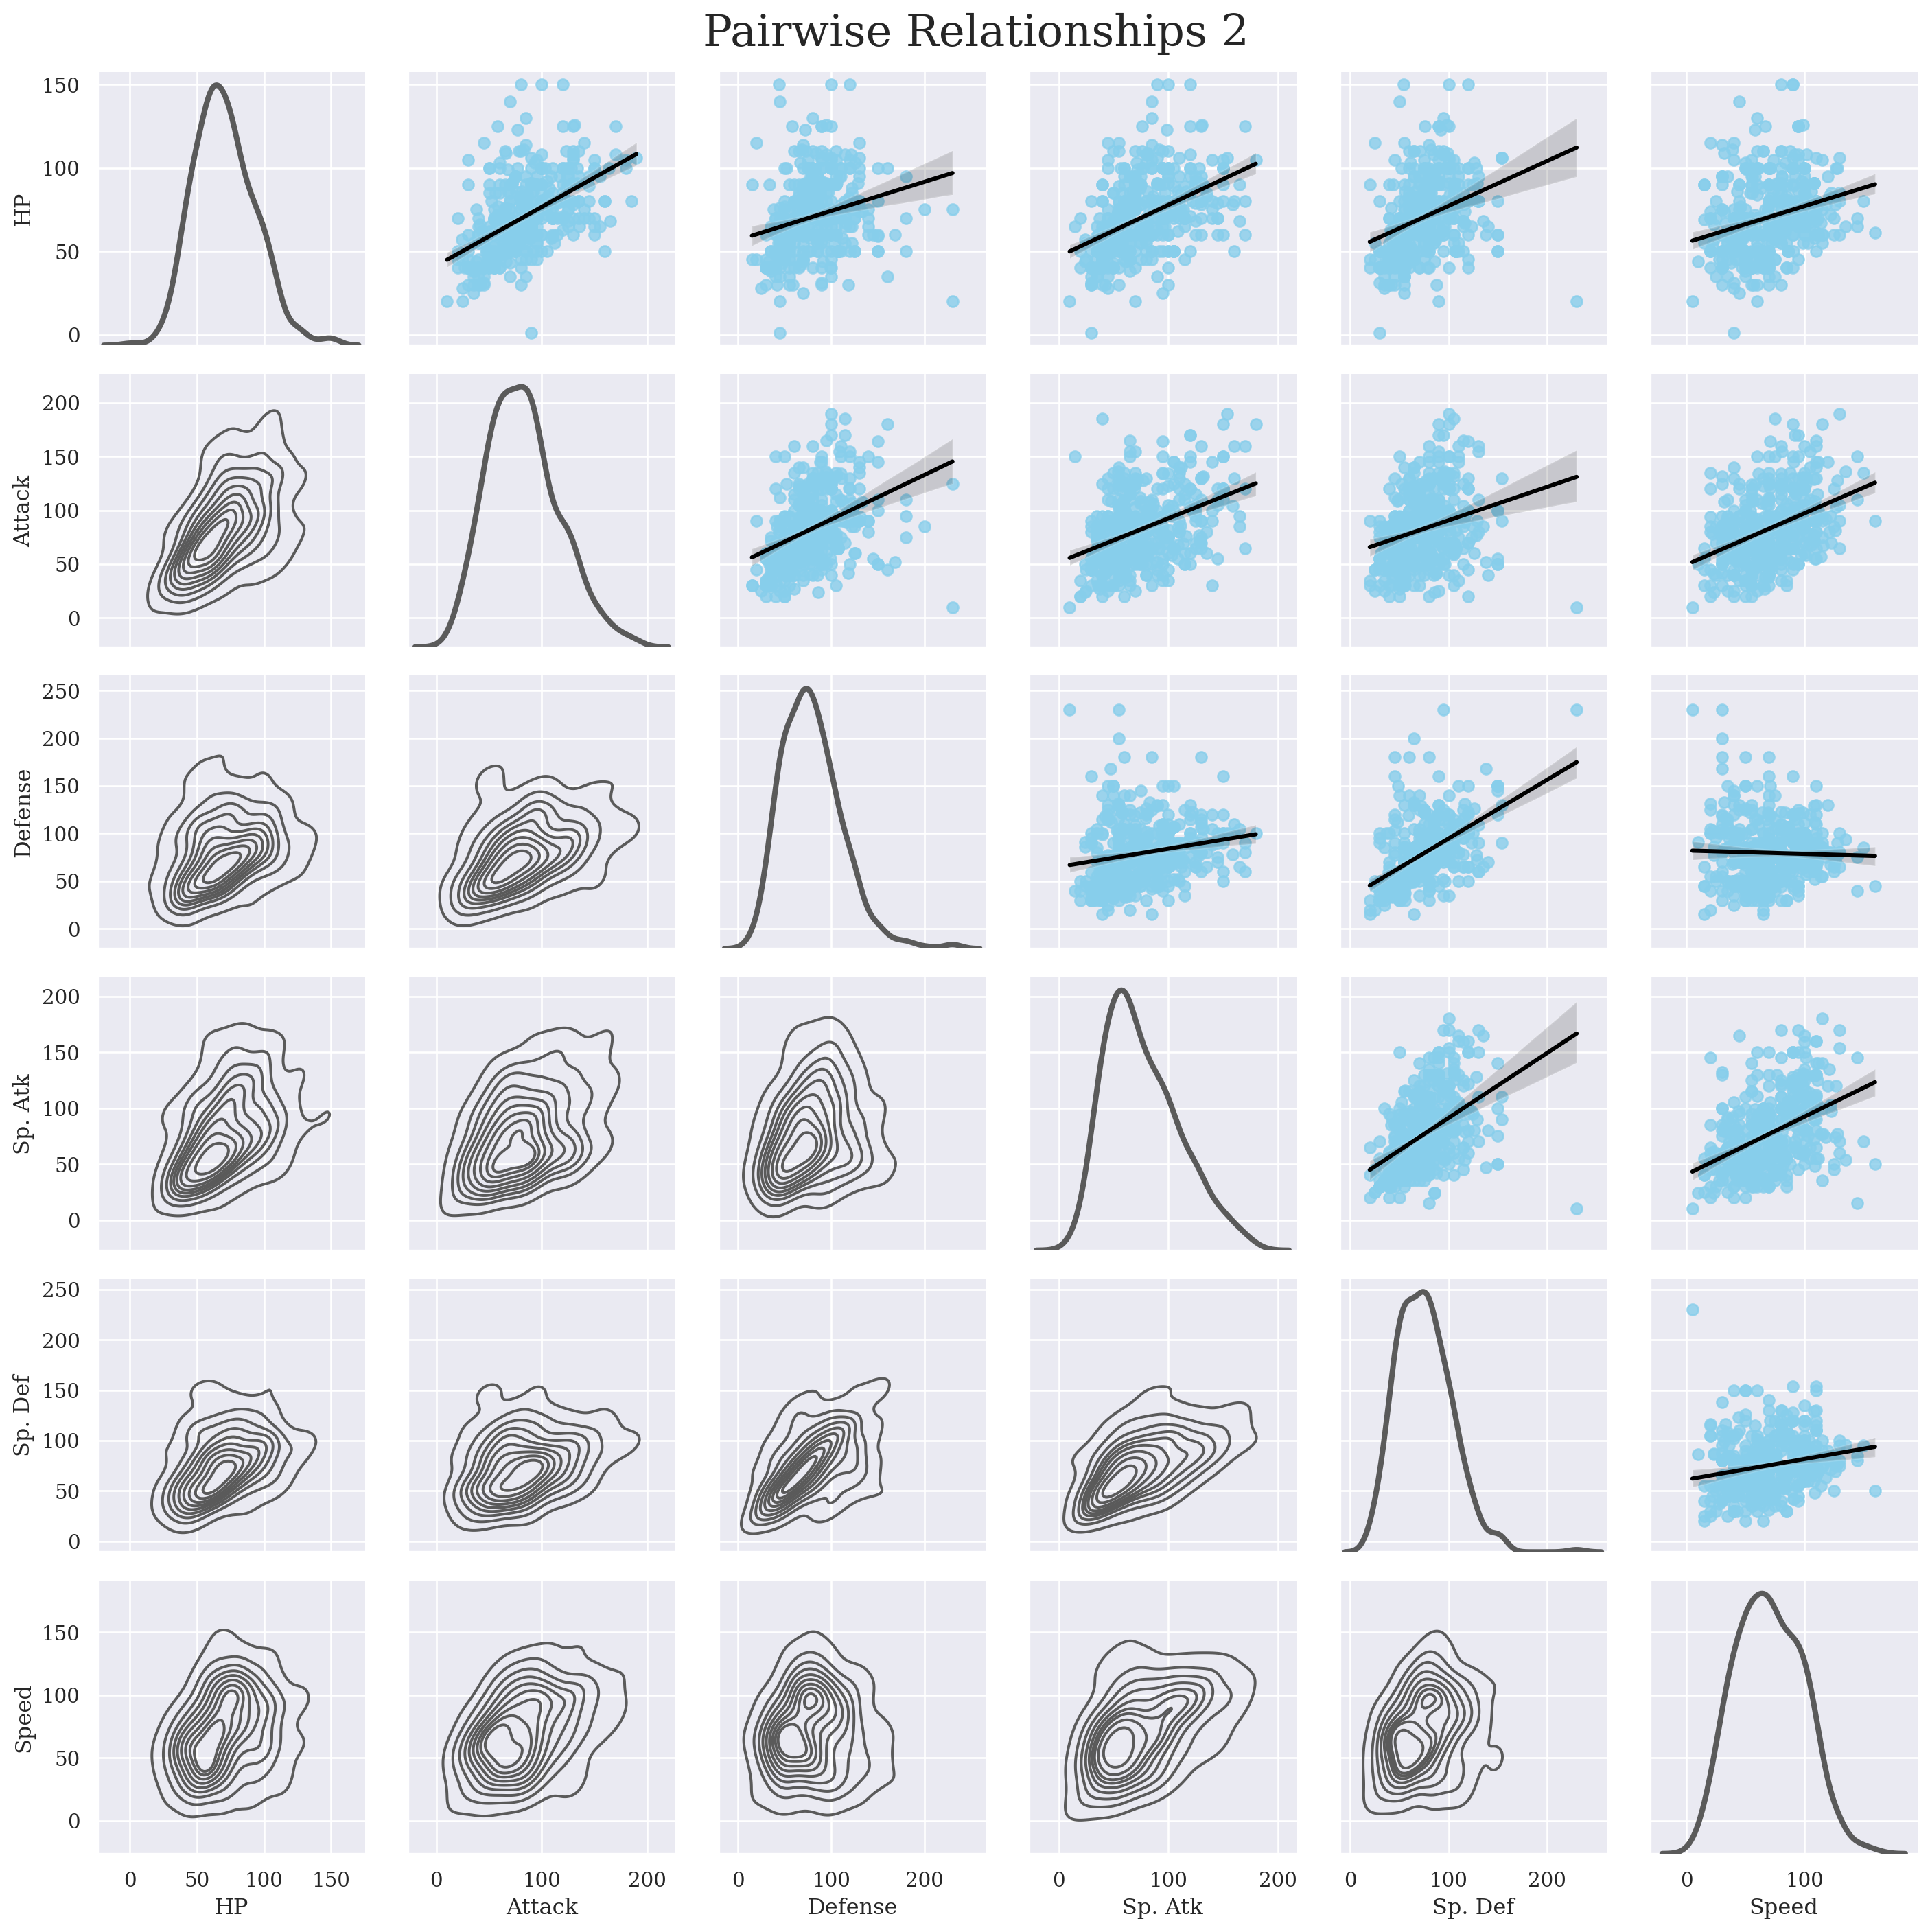

In [28]:
g = sns.PairGrid(df_vis.loc[:,col], diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.regplot, line_kws={"color":"black"}, scatter_kws={"color":"skyblue"})
g.map_diag(sns.kdeplot, lw=3);
g.fig.figsize = (18, 5)
g.fig.dpi = 192
g.fig.suptitle("Pairwise Relationships 2", fontsize=24);
g.fig.subplots_adjust(top=0.95)

### **_Pearson Correlation Heatmap_**

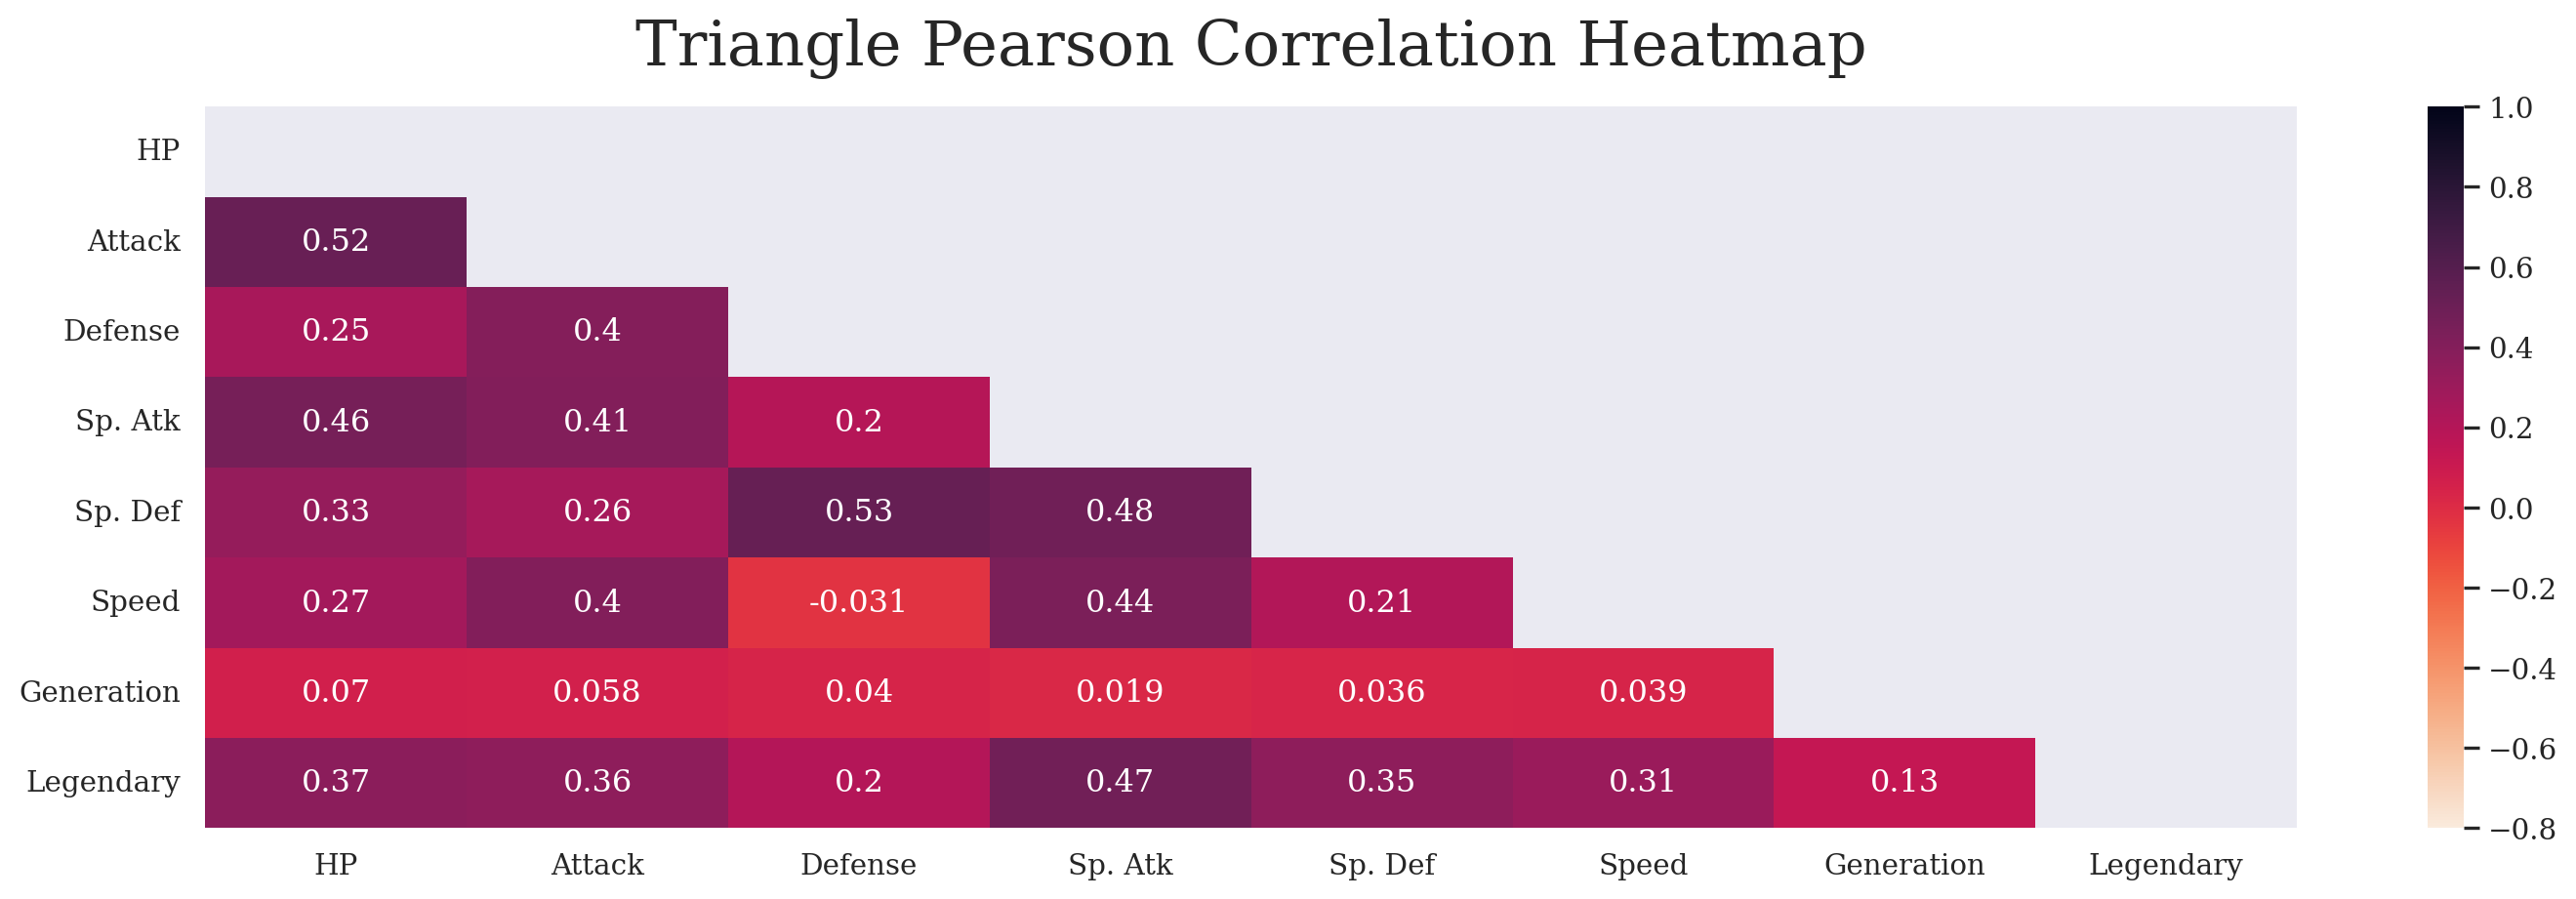

In [29]:
# 0.26 - 0.49 weak corr

plt.figure(figsize=(18, 5), dpi=192)
mask = np.triu(np.ones_like(df_vis.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_vis.corr(), mask=mask, vmin=-0.8, vmax=1, annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True))
heatmap.set_title("Triangle Pearson Correlation Heatmap", fontdict={"fontsize": 24}, pad=16);

### **_Regression Plots_**

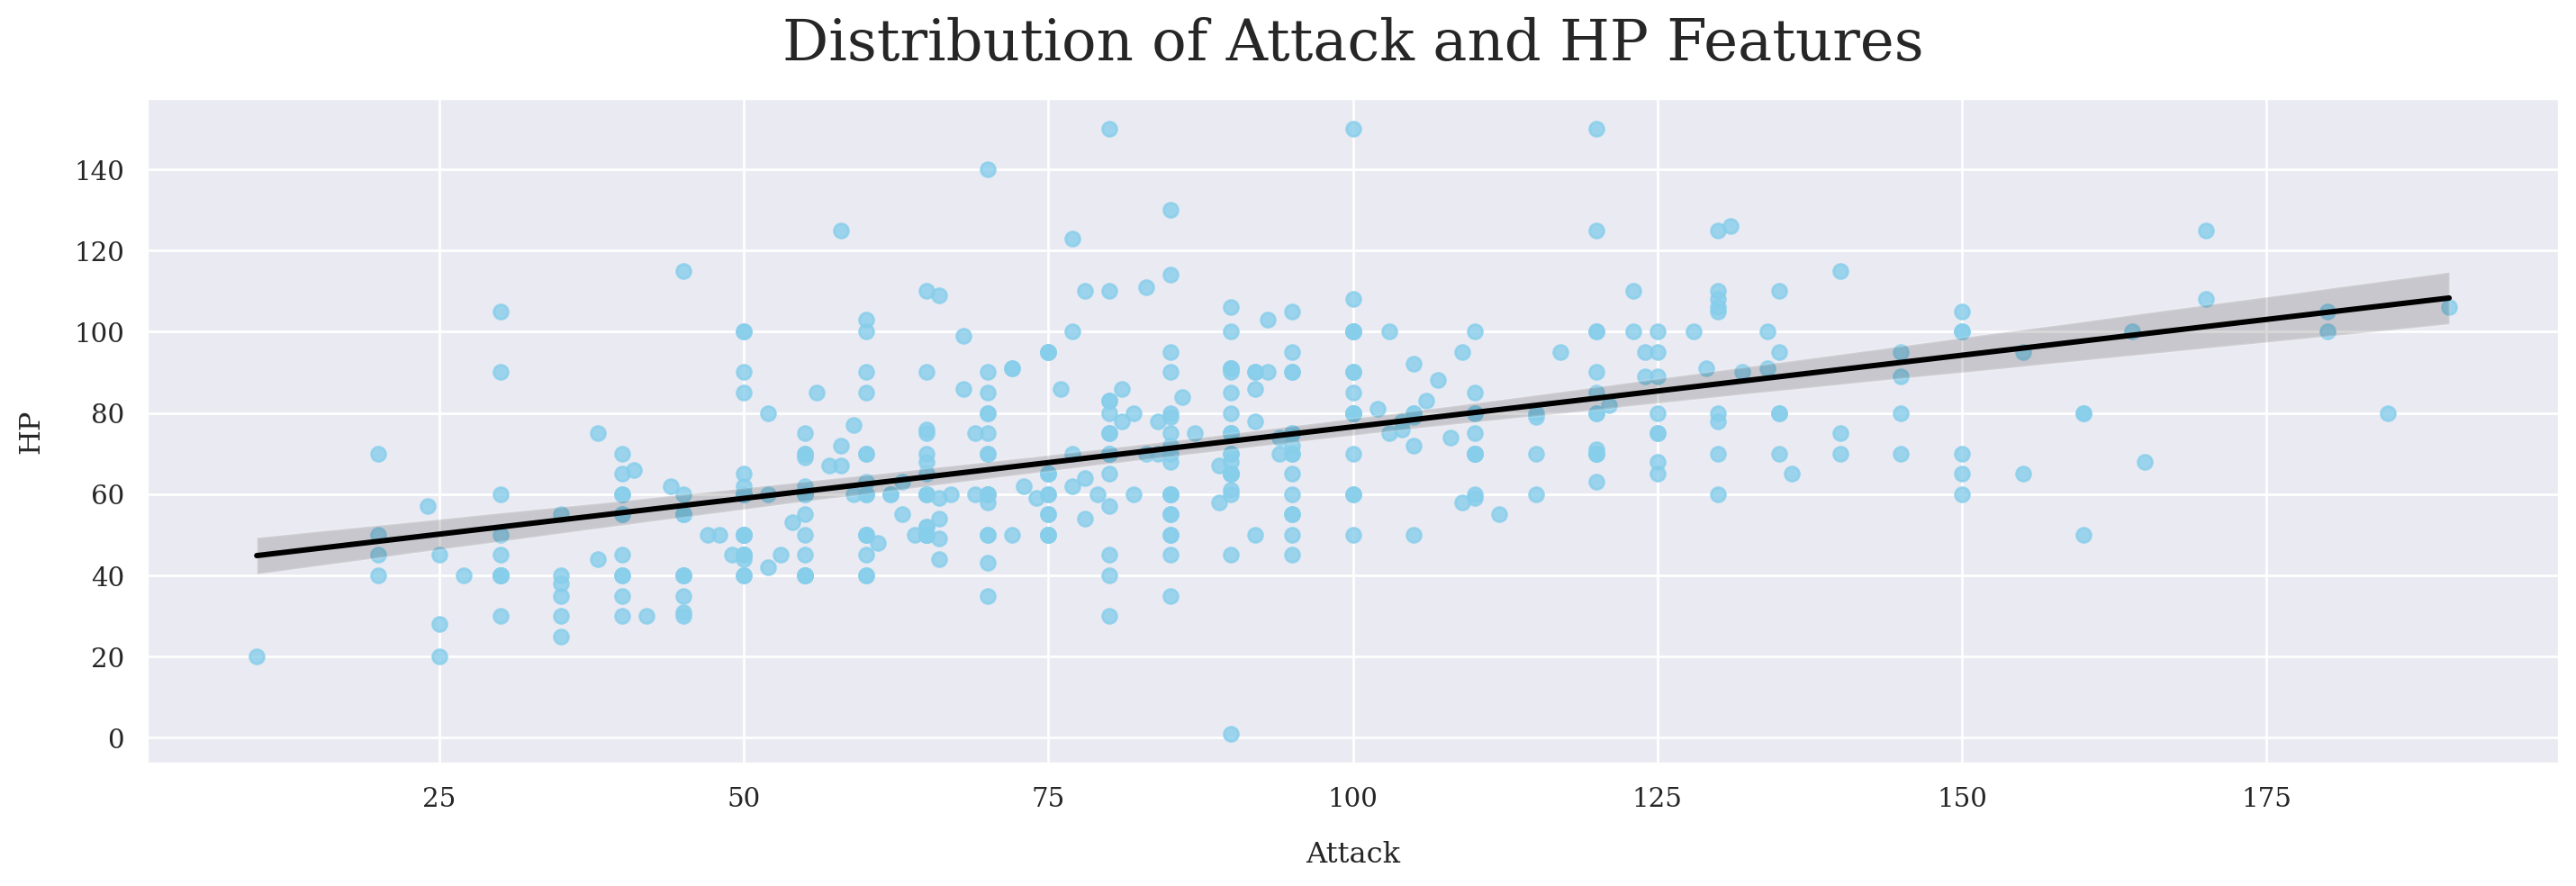

In [30]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.regplot(x="Attack", y="HP", data=df_vis, line_kws={"color":"black"}, scatter_kws={"color":"skyblue"})
plt.xlabel("Attack", labelpad=12)
plt.ylabel("HP", labelpad=12)
plt.title("Distribution of Attack and HP Features", fontdict={"fontsize": 24}, pad=16);

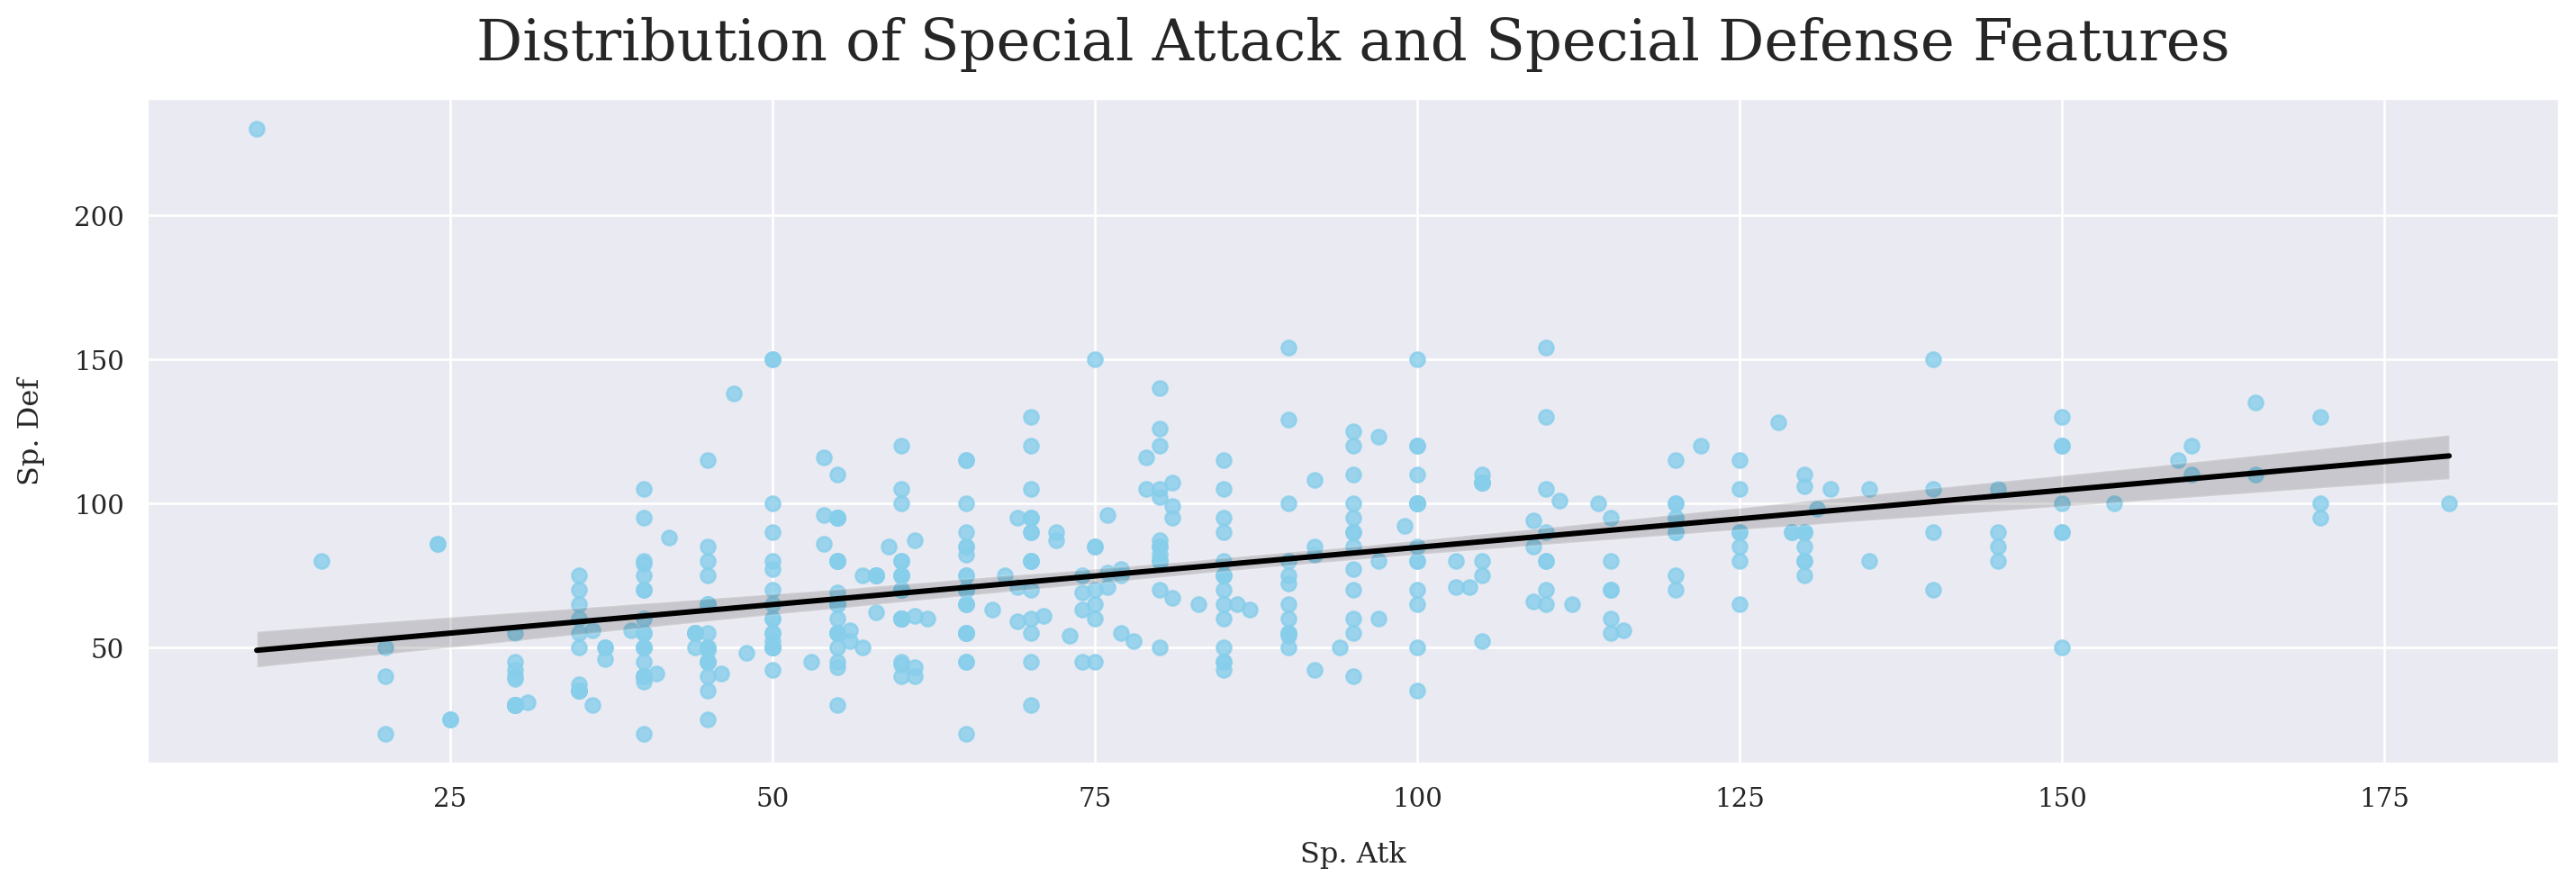

In [31]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.regplot(x="Sp. Atk", y="Sp. Def", data=df_vis, line_kws={"color":"black"}, scatter_kws={"color":"skyblue"})
plt.xlabel("Sp. Atk", labelpad=12)
plt.ylabel("Sp. Def", labelpad=12)
plt.title("Distribution of Special Attack and Special Defense Features", fontdict={"fontsize": 24}, pad=16);

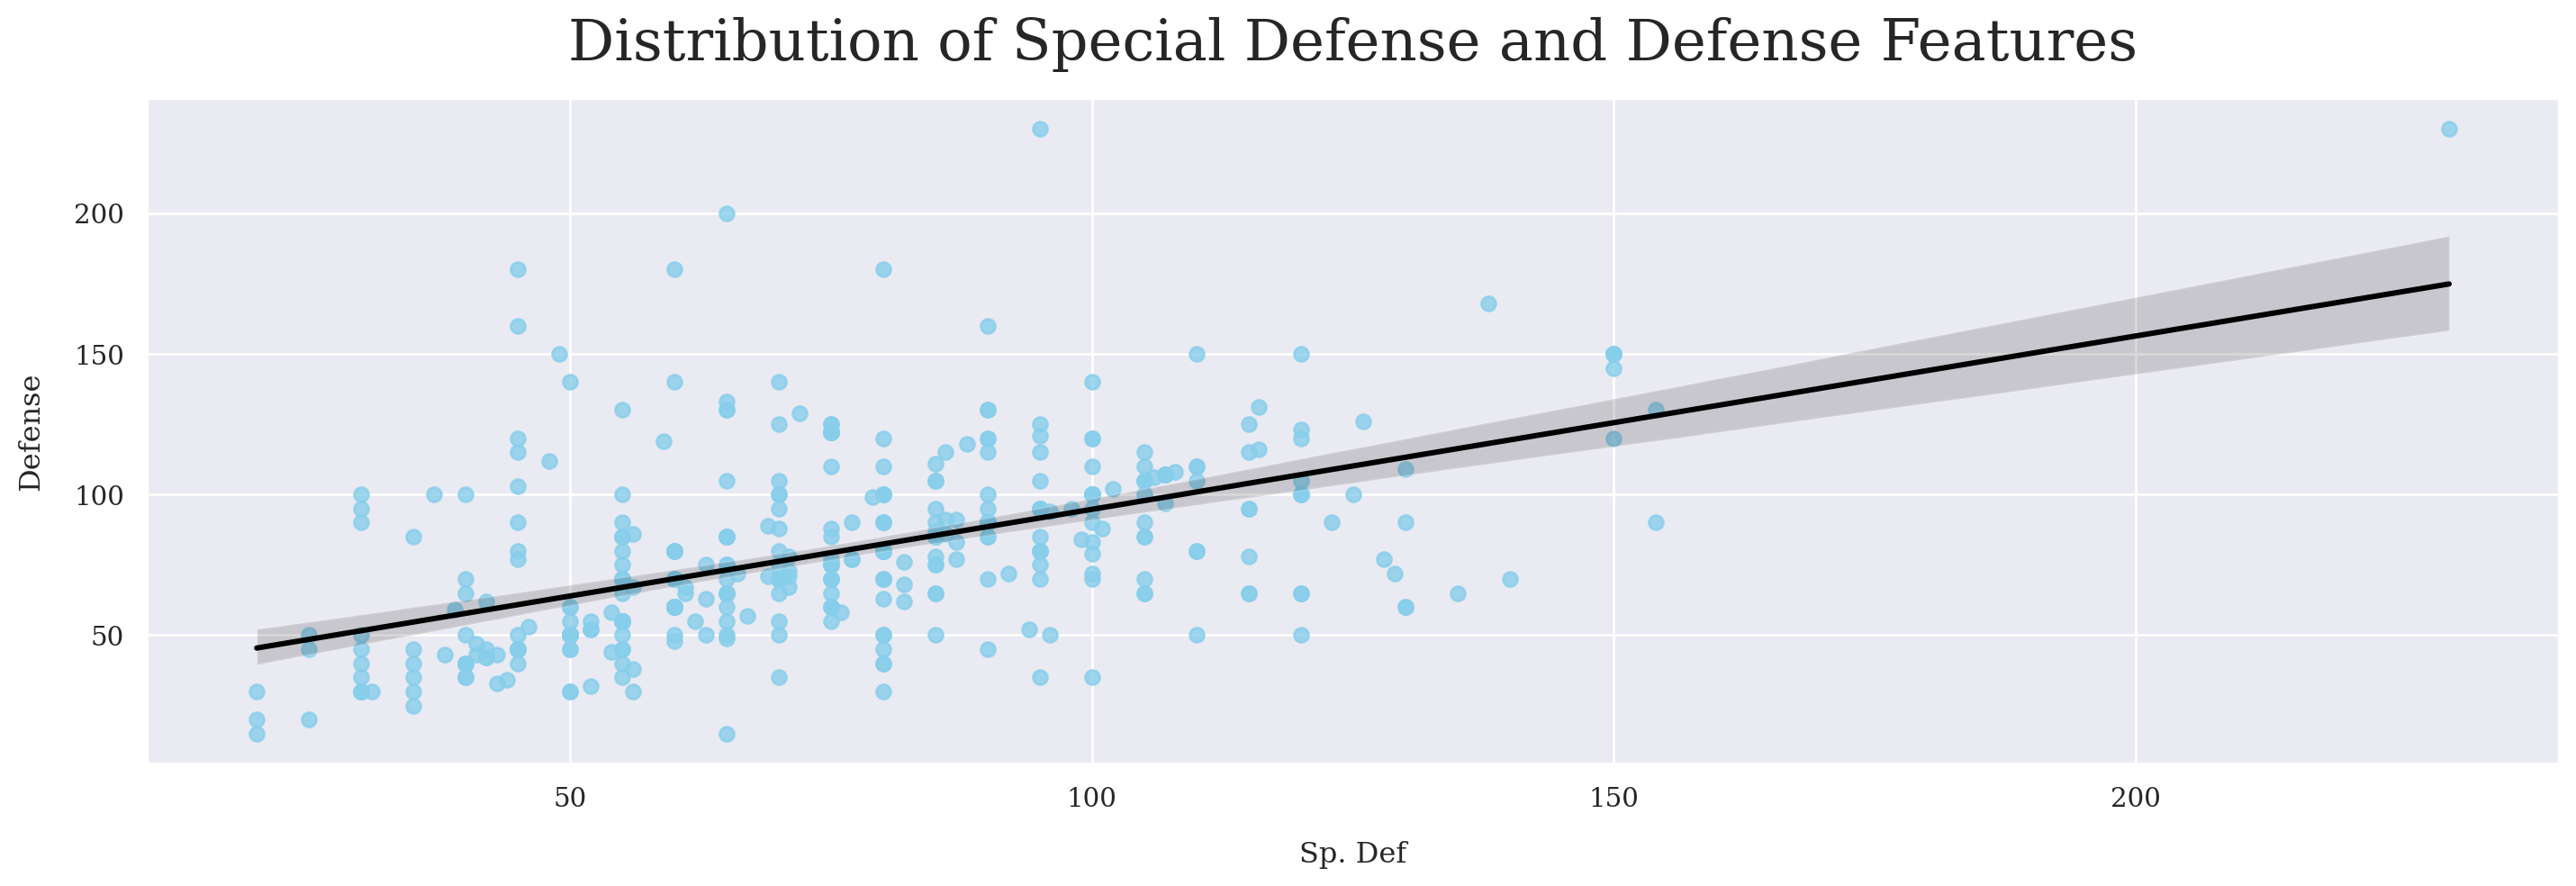

In [32]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.regplot(x="Sp. Def", y="Defense", data=df_vis, line_kws={"color":"black"}, scatter_kws={"color":"skyblue"})
plt.xlabel("Sp. Def", labelpad=12)
plt.ylabel("Defense", labelpad=12)
plt.title("Distribution of Special Defense and Defense Features", fontdict={"fontsize": 24}, pad=16);

### **_Box Plots_**

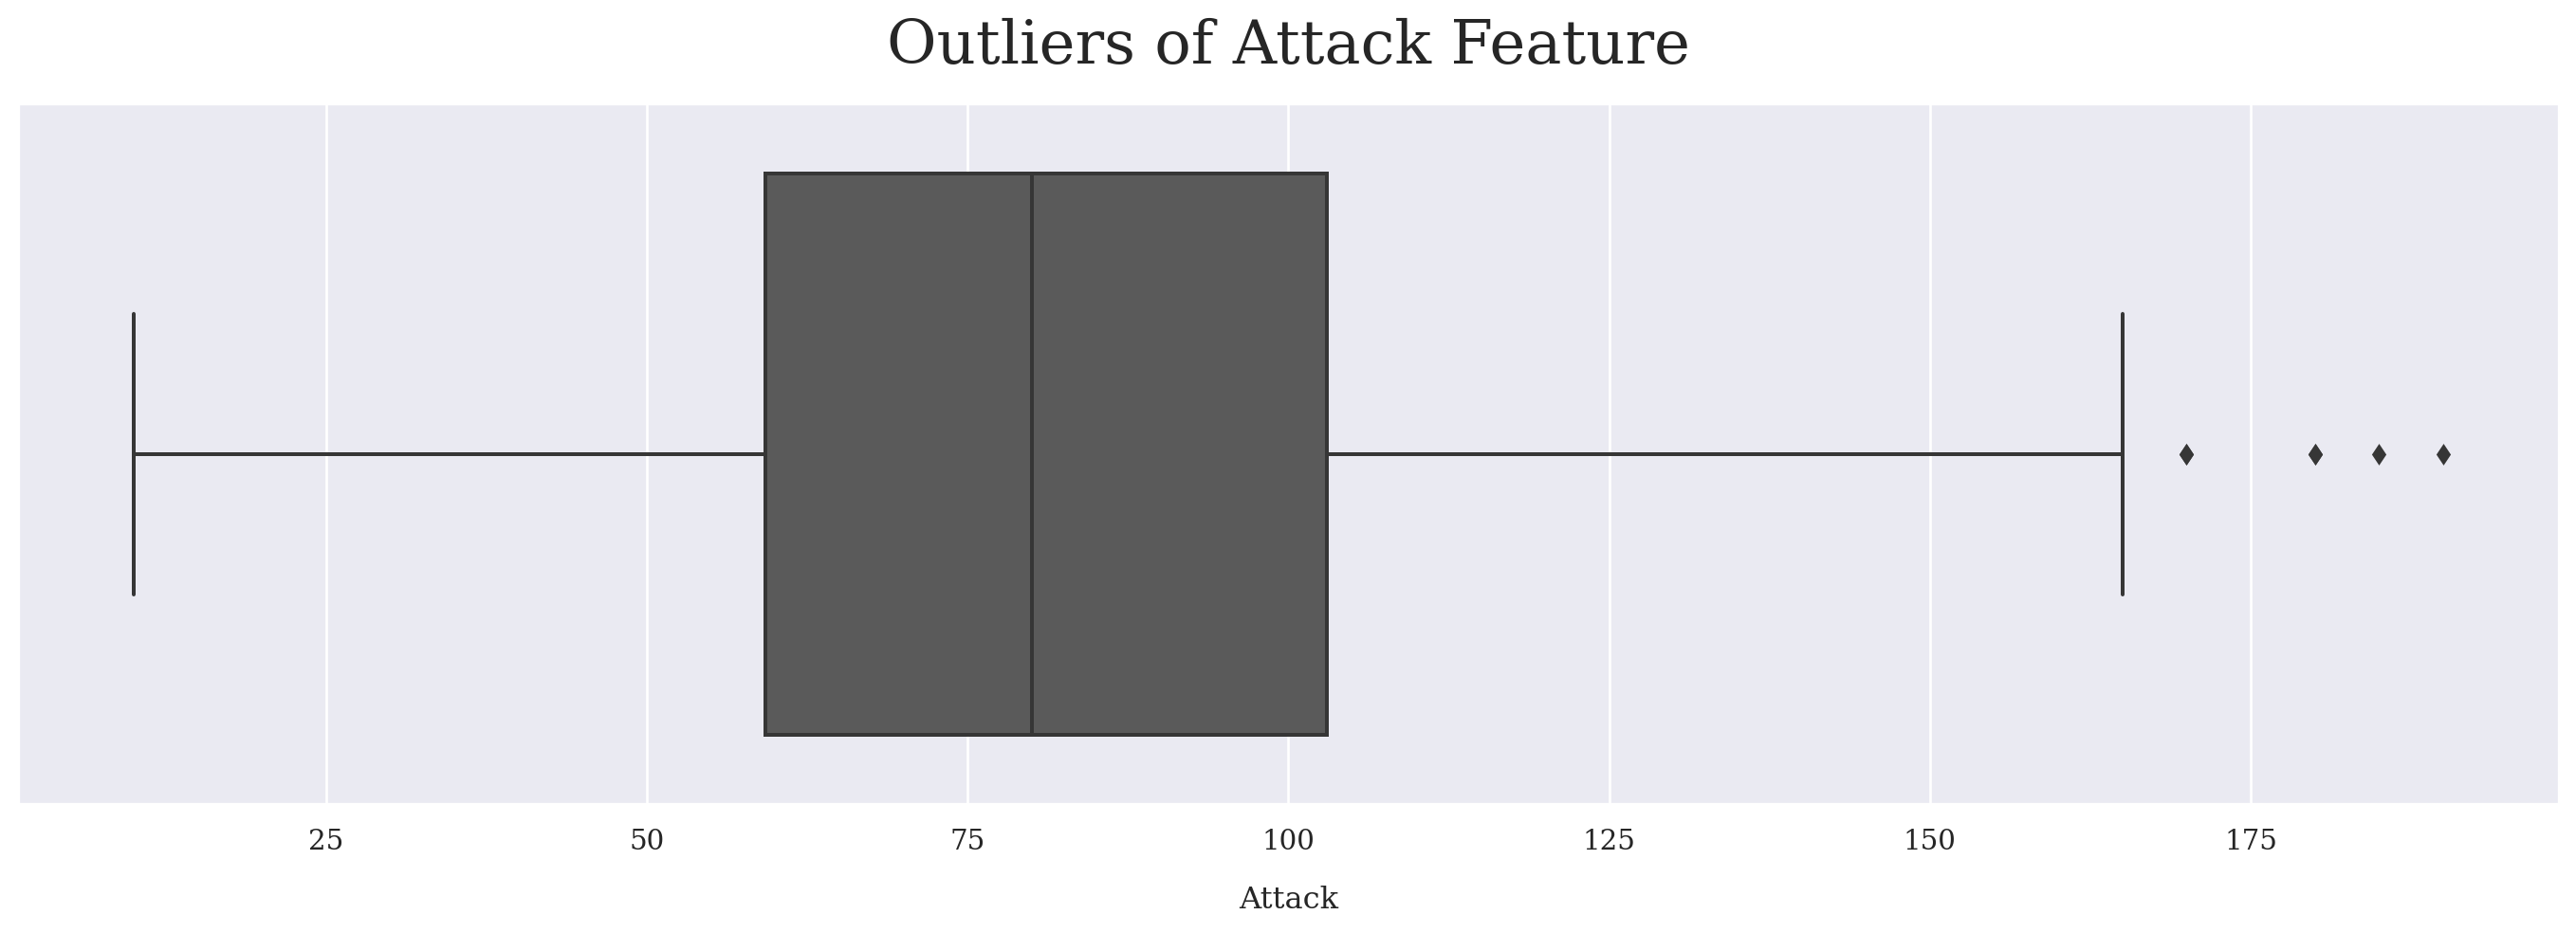

In [33]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.boxplot(x="Attack", data=df_vis);
plt.xlabel("Attack", labelpad=12);
plt.title("Outliers of Attack Feature", fontdict={"fontsize": 24}, pad=16);

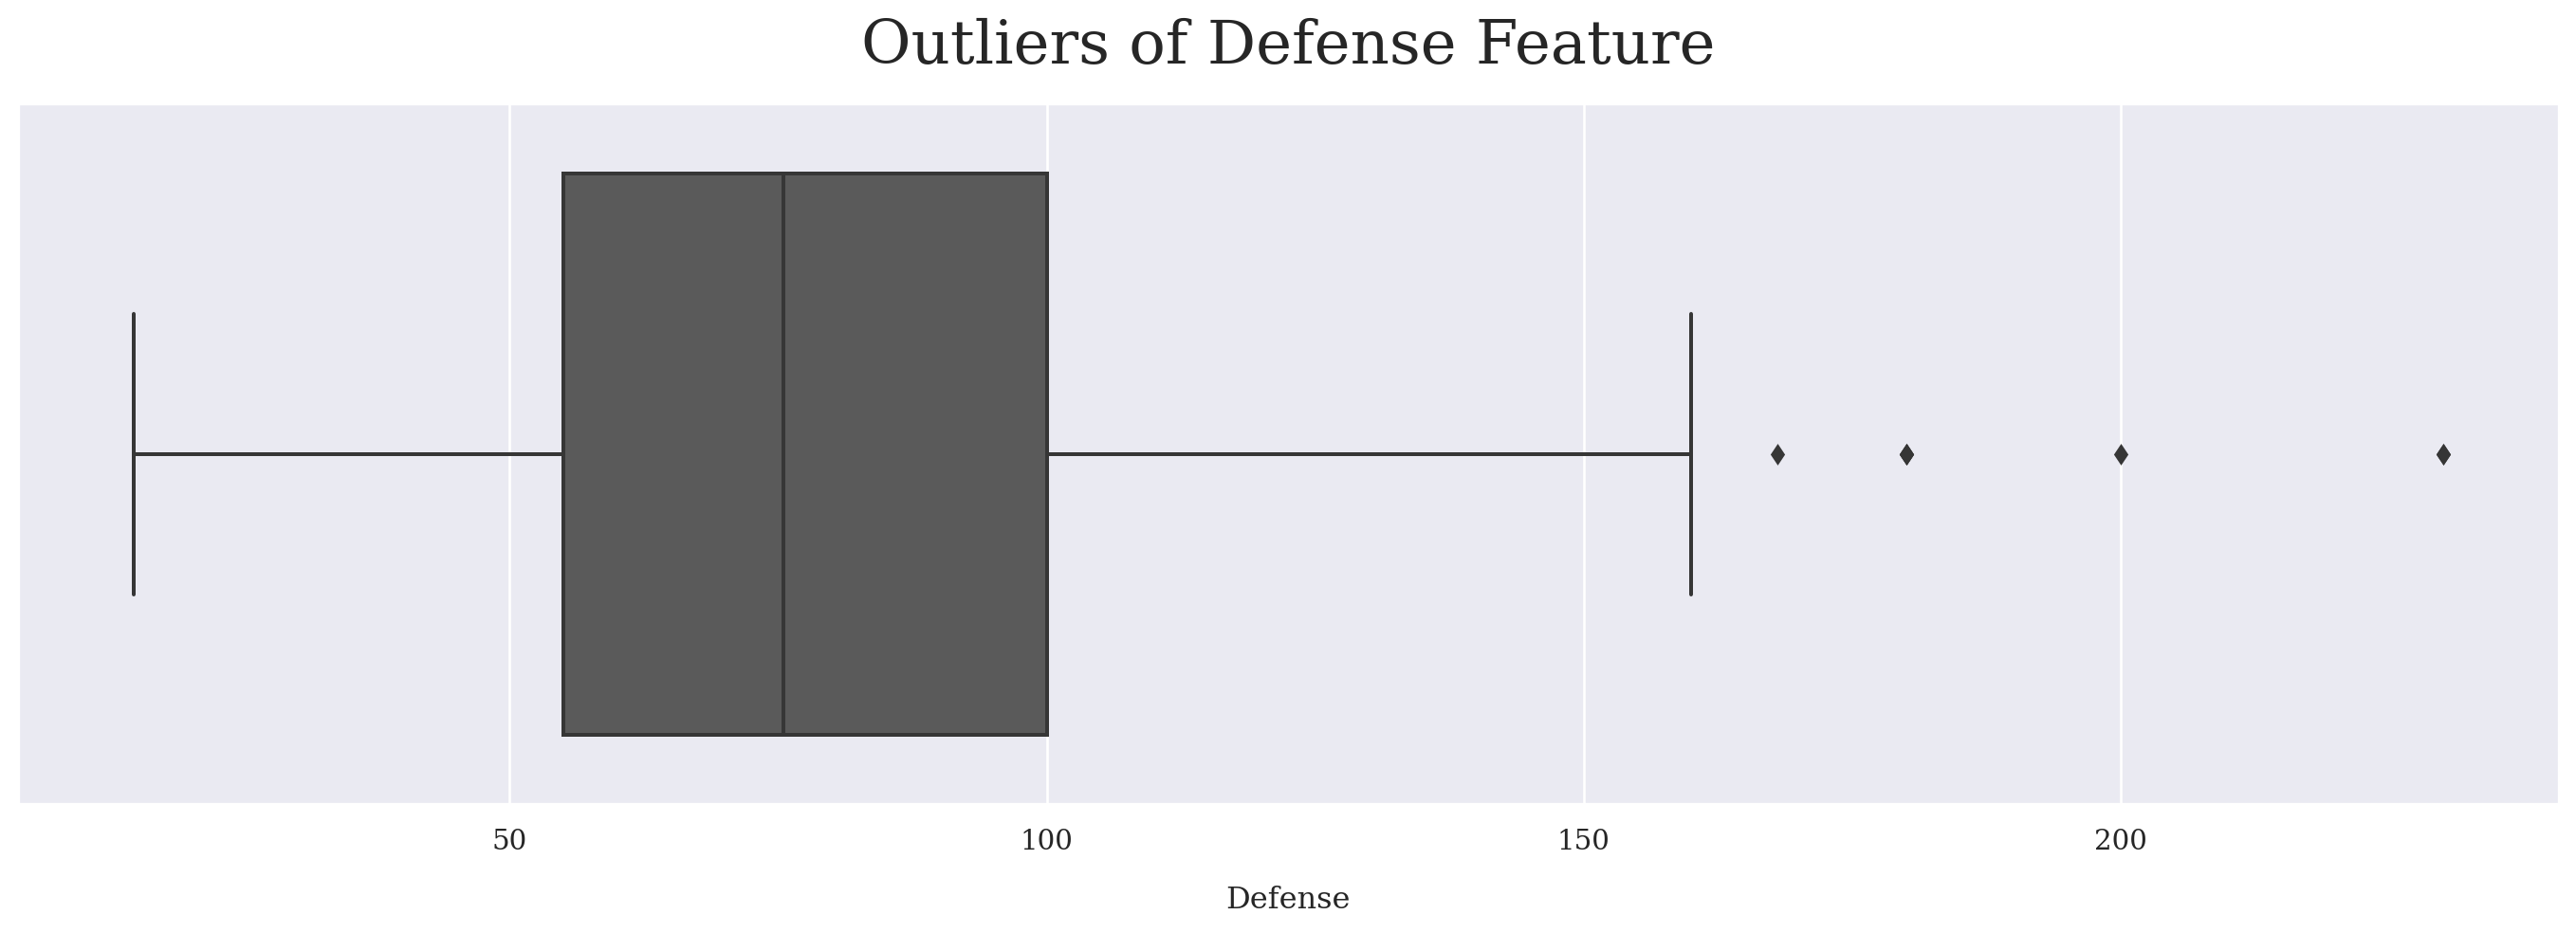

In [34]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.boxplot(x="Defense", data=df_vis);
plt.xlabel("Defense", labelpad=12);
plt.title("Outliers of Defense Feature", fontdict={"fontsize": 24}, pad=16);

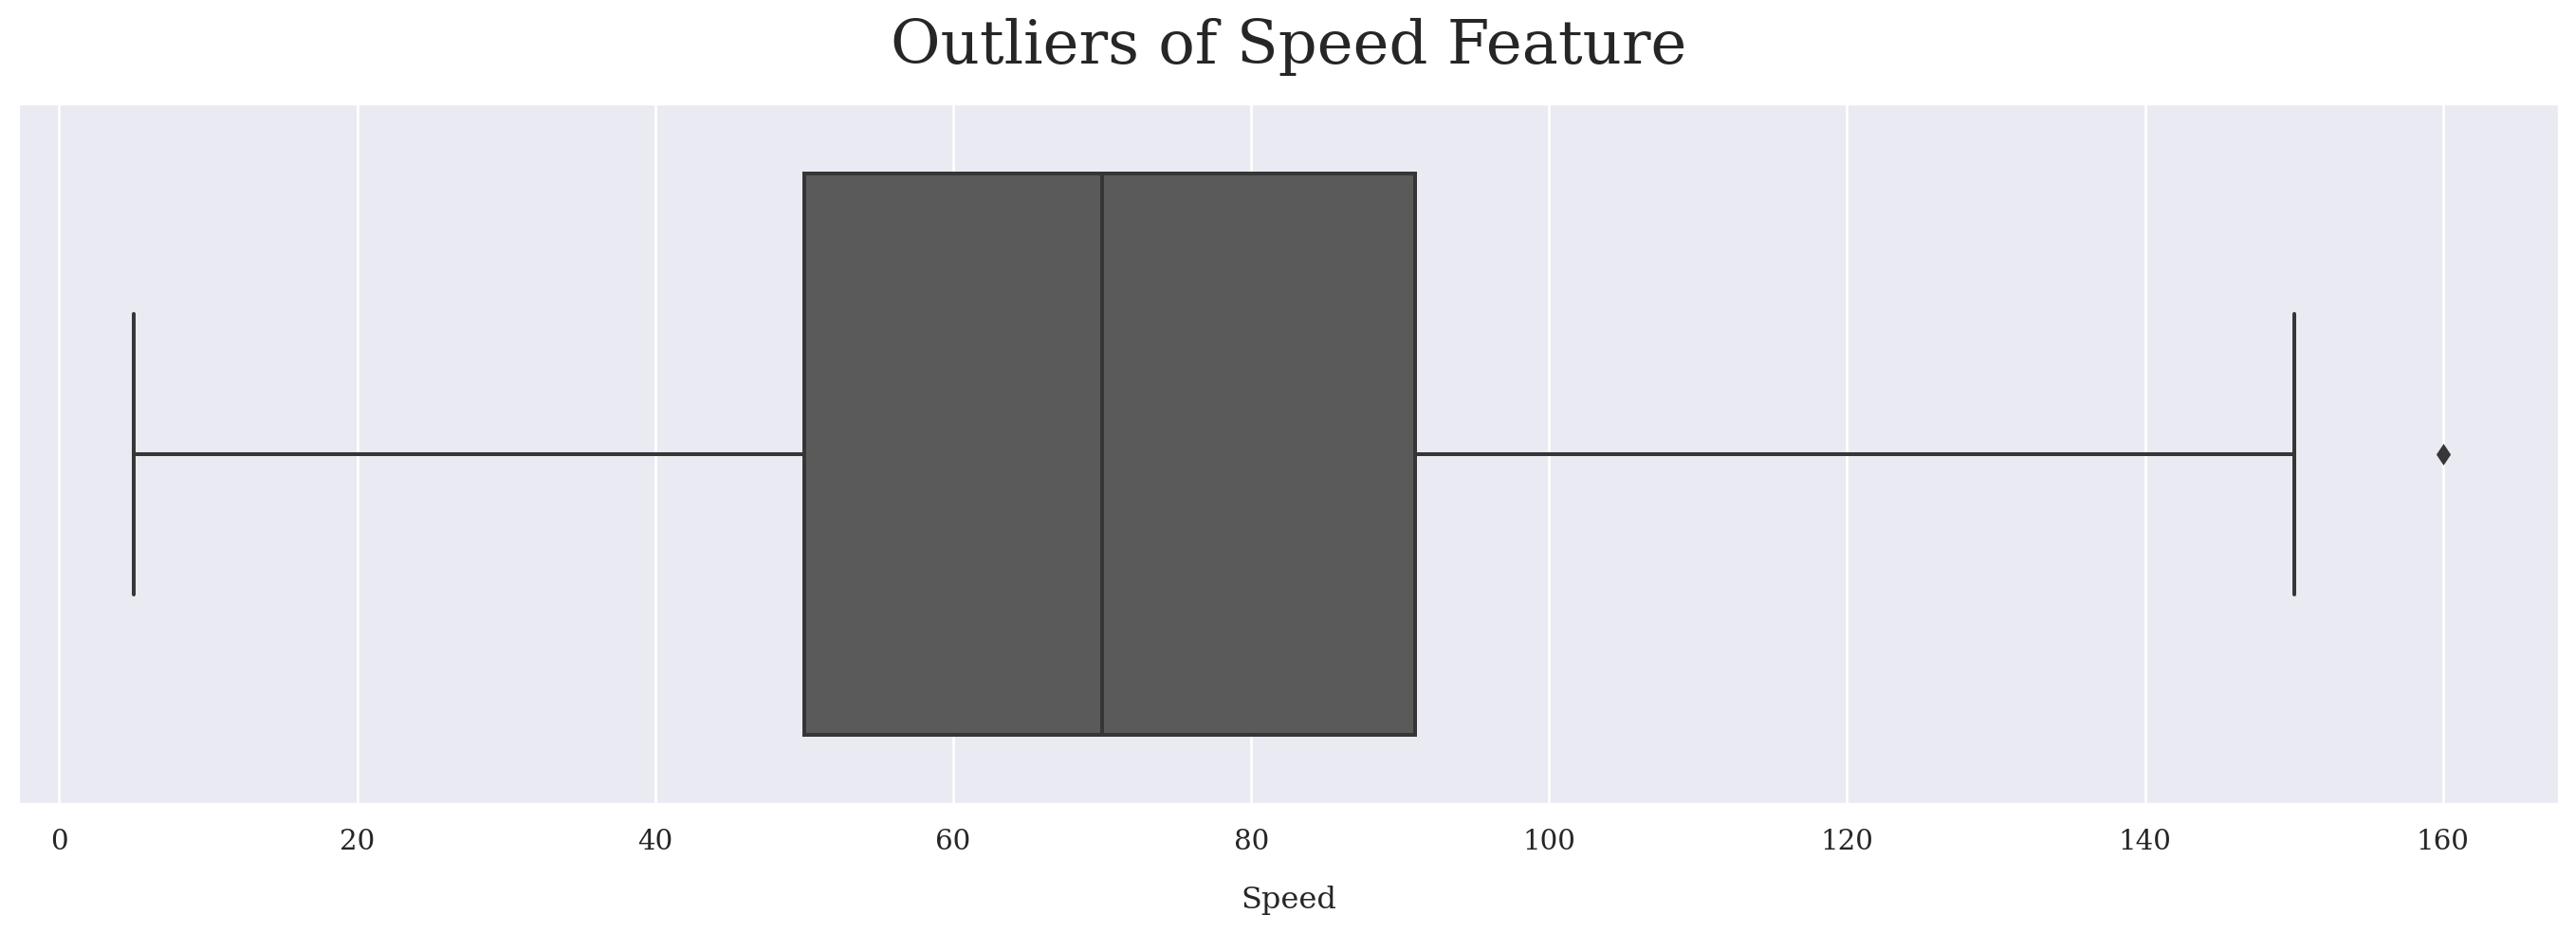

In [35]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.boxplot(x="Speed", data=df_vis);
plt.xlabel("Speed", labelpad=12);
plt.title("Outliers of Speed Feature", fontdict={"fontsize": 24}, pad=16);

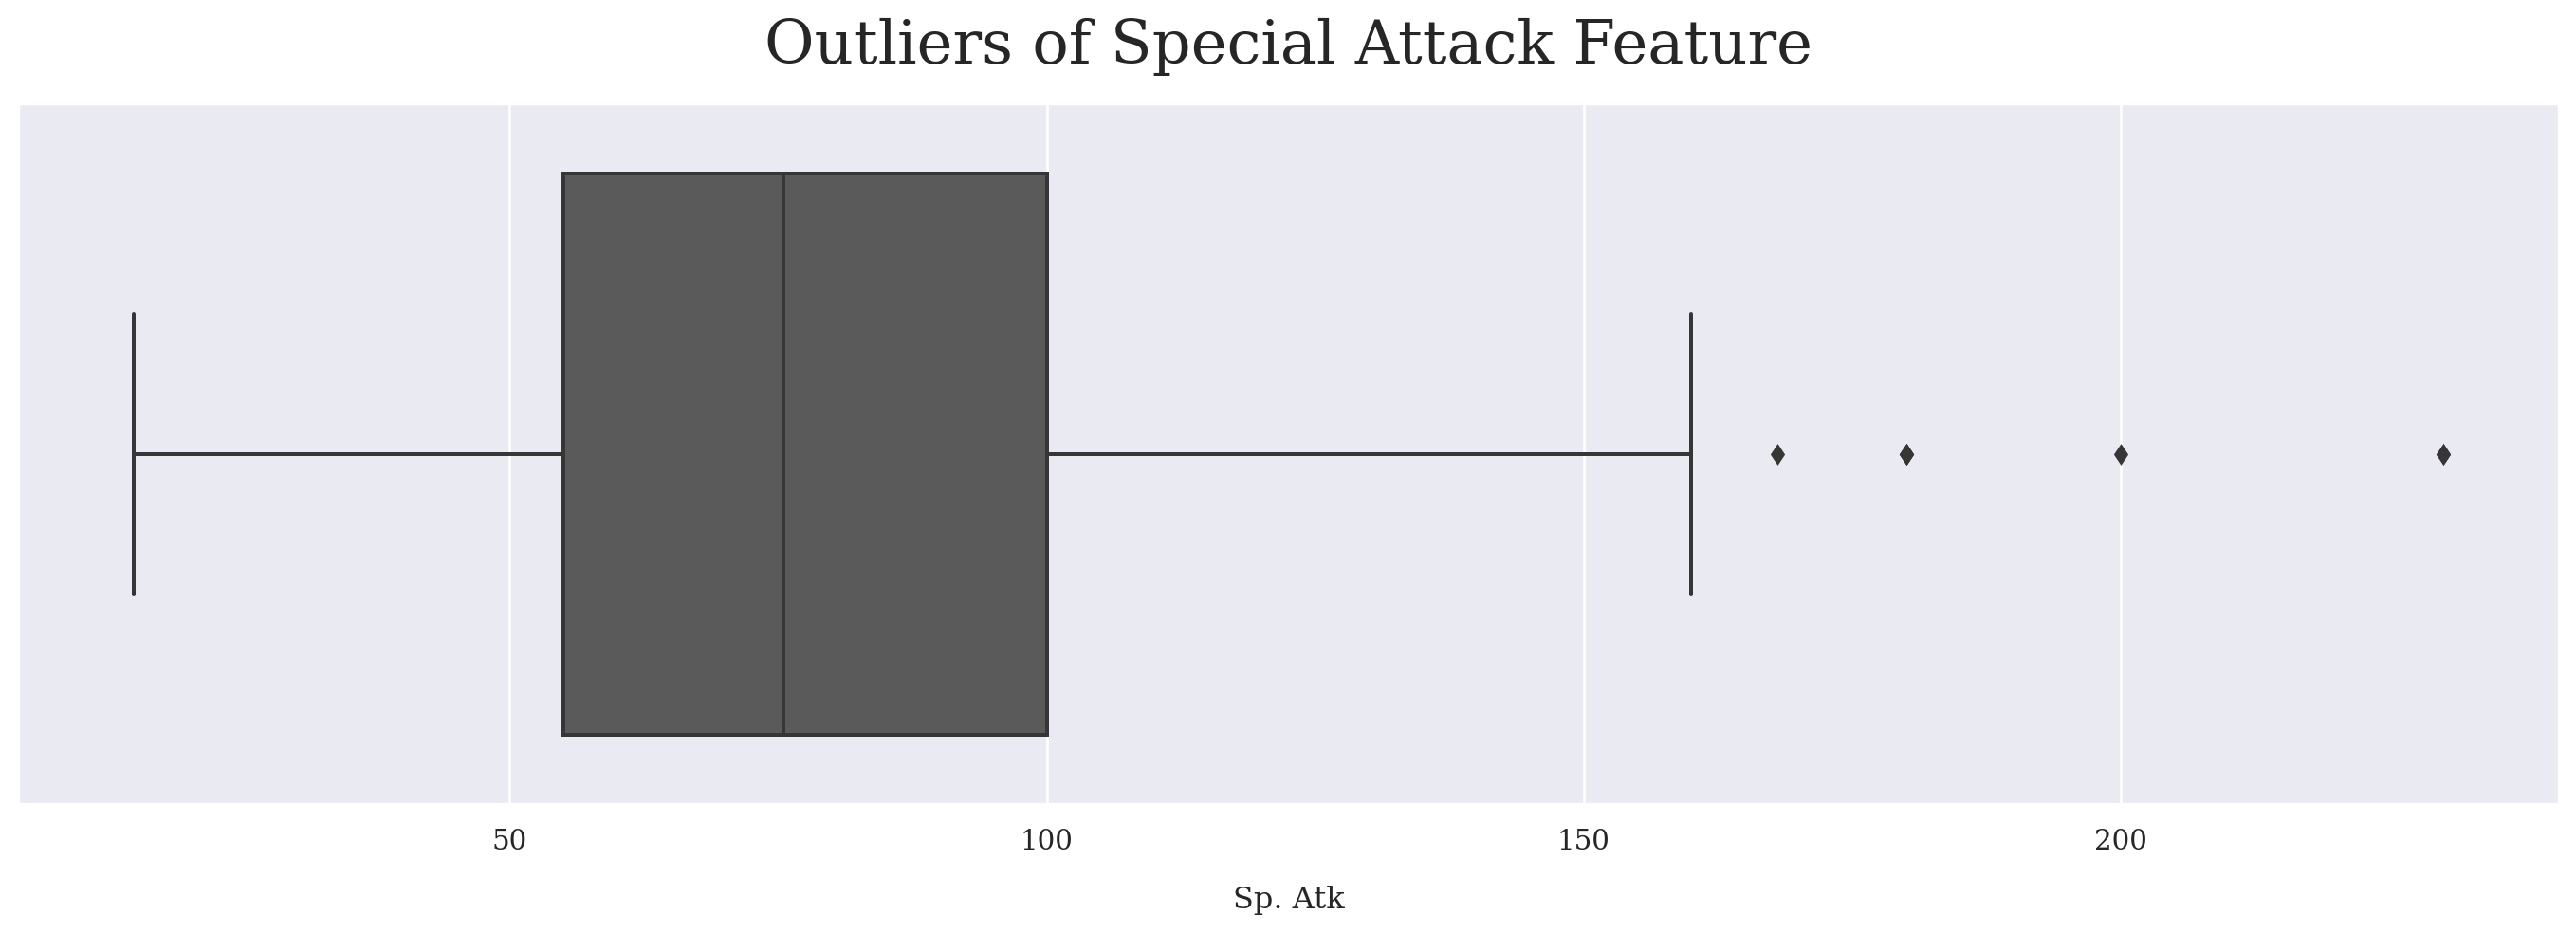

In [36]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.boxplot(x="Defense", data=df_vis);
plt.xlabel("Sp. Atk", labelpad=12);
plt.title("Outliers of Special Attack Feature", fontdict={"fontsize": 24}, pad=16);

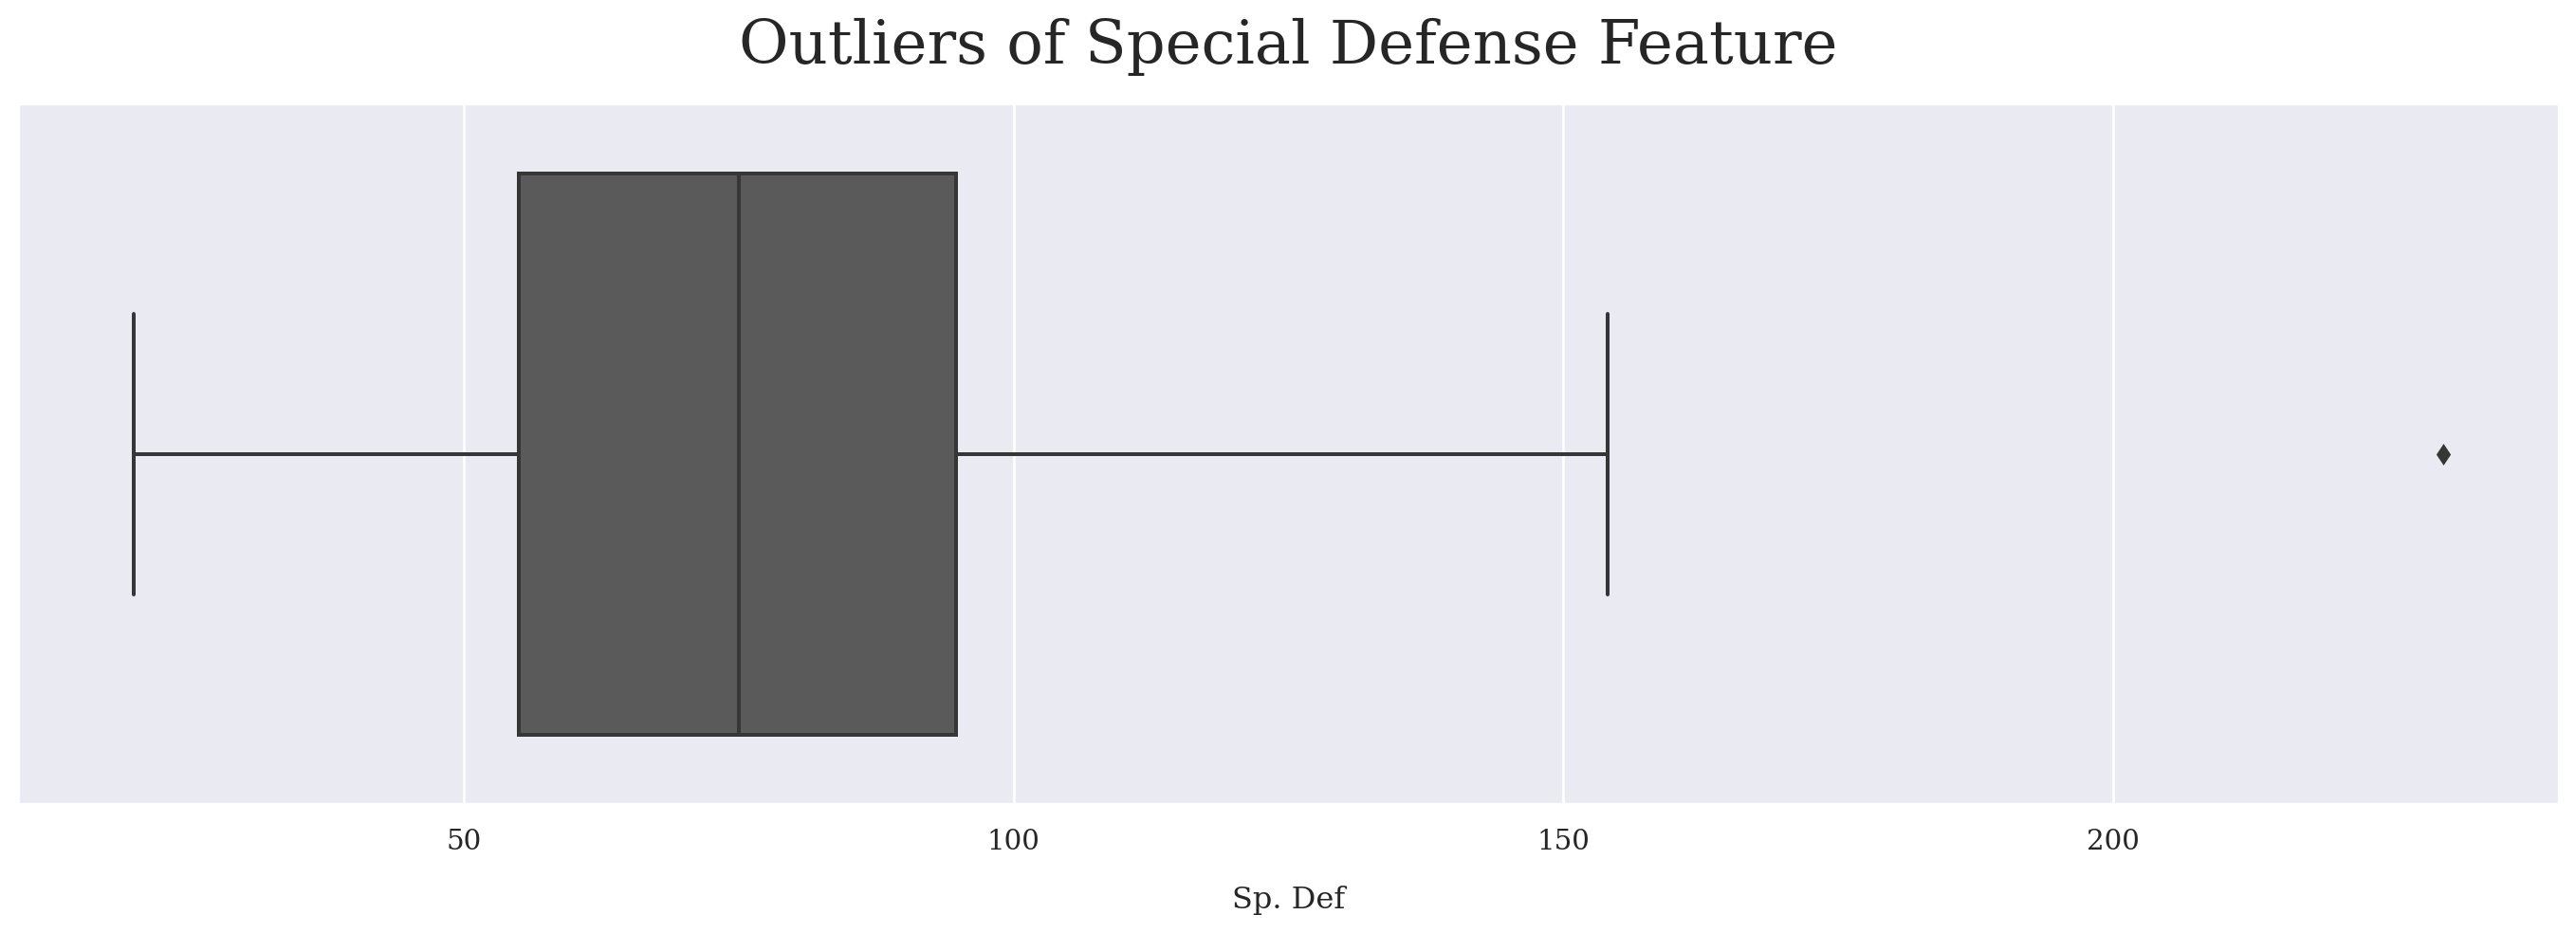

In [37]:
plt.figure(figsize=(18,5), dpi=192)
ax = sns.boxplot(x="Sp. Def", data=df_vis);
plt.xlabel("Sp. Def", labelpad=12);
plt.title("Outliers of Special Defense Feature", fontdict={"fontsize": 24}, pad=16);

# **_Feature Engineering_**

In [38]:
style_df(combat_data.head())

In [39]:
%%time
df["Battles_Count"] = 0
for index, row in combat_data.iterrows():
    first_pokemon = row['First_pokemon']
    second_pokemon = row['Second_pokemon']
    df.loc[df['#'] == first_pokemon, 'Battles_Count'] += 1
    df.loc[df['#'] == second_pokemon, 'Battles_Count'] += 1

CPU times: user 1min 43s, sys: 59.5 ms, total: 1min 43s
Wall time: 1min 43s


In [40]:
%%time
df["Win_Count"] = 0
for index, row in combat_data.iterrows():
    winner = row['Winner']
    df.loc[df['#'] == winner, 'Win_Count'] += 1

CPU times: user 52.9 s, sys: 58.4 ms, total: 53 s
Wall time: 52.9 s


In [41]:
df['Win_Percentage'] = (df['Win_Count'] / df['Battles_Count']) * 100
df['Win_Percentage'] = df['Win_Percentage'].apply(lambda x: 0 if np.isnan(x) else x)

In [42]:
df = df.sort_values(by='#')
df = df.reset_index(drop=True)

In [43]:
style_df(df.head())

## **_Split Columns_**

In [44]:
def split_columns(data):
    cat_cols = []
    num_cols = []
    for col in data.columns:
        if data[col].dtype == "object" or data[col].dtype == "bool" or ((data[col].dtype == "int64") and (data[col].value_counts().count() <= 10)):
            cat_cols.append(col)
        if  data[col].dtype == "float" or ((data[col].dtype == "int64") and (data[col].value_counts().count() > 10)):  # Non-Binary
            num_cols.append(col)

    return data[num_cols], data[cat_cols]

num_cols, cat_cols = split_columns(df)
style_df(cat_cols.head())

# **_Data Preprocessing_**

In [45]:
style_df(combat_data.head())

In [46]:
style_df(test_data.head())

In [47]:
style_df(df.head())

## **_Categorical Columns_**

### **_"Type 1" Column_**

In [48]:
df["Type 1"].value_counts()

Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64

In [49]:
map_new = {"Water":"0", "Normal":"1", "Grass":"2", "Bug":"3", "Psychic":"4", "Fire":"5", "Electric":"6",
           "Rock":"7", "Dragon":"8", "Ground":"9", "Ghost":"10", "Dark":"11", "Poison":"12", "Steel":"13",
           "Fighting":"14", "Ice":"15", "Fairy":"16", "Flying":"17"}

df["Type 1"] = df["Type 1"].map(map_new)

In [50]:
df.rename(columns={"Type 1":"Type_1"}, inplace=True)

In [51]:
style_df(df.head())

In [52]:
df["Type_1"] = df["Type_1"].astype("category")
df["Type_1"].dtype

CategoricalDtype(categories=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17',
                  '2', '3', '4', '5', '6', '7', '8', '9'],
, ordered=False)

### **_"Type 2" Column_**

In [53]:
df["Type 2"].value_counts()

Flying      97
Ground      35
Poison      34
Psychic     33
Fighting    26
Grass       25
Fairy       23
Steel       22
Dark        20
Dragon      18
Water       14
Ghost       14
Ice         14
Rock        14
Fire        12
Electric     6
Normal       4
Bug          3
Name: Type 2, dtype: int64

In [54]:
map_new = {"Water":"0", "Normal":"1", "Grass":"2", "Bug":"3", "Psychic":"4", "Fire":"5", "Electric":"6",
           "Rock":"7", "Dragon":"8", "Ground":"9", "Ghost":"10", "Dark":"11", "Poison":"12", "Steel":"13", 
           "Fighting":"14", "Ice":"15", "Fairy":"16", "Flying":"17"}

df["Type 2"] = df["Type 2"].map(map_new)

In [55]:
df.rename(columns={"Type 2":"Type_2"}, inplace=True)

In [56]:
style_df(df.head())

In [57]:
df["Type_2"] = df["Type_2"].astype("category")
df["Type_2"].dtype

CategoricalDtype(categories=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17',
                  '2', '3', '4', '5', '6', '7', '8', '9'],
, ordered=False)

### **_"Generation" Column_**

In [58]:
df["Generation"].value_counts()

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64

In [59]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Generation"] = label_encoder.fit_transform(df["Generation"].astype(str))

In [60]:
style_df(df.head())

In [61]:
df["Generation"] = df["Generation"].astype("category")
df["Generation"].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5], ordered=False)

### **_"Legendary" Column_**

In [62]:
df["Legendary"].value_counts()

False    735
True      65
Name: Legendary, dtype: int64

In [63]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Legendary"] = label_encoder.fit_transform(df["Legendary"].astype(str))

In [64]:
style_df(df.head())

In [65]:
df["Legendary"] = df["Legendary"].astype("category")
df["Legendary"].dtype

CategoricalDtype(categories=[0, 1], ordered=False)

## **_Numerical Columns_**

### **_Sp. Atk Column_**

In [66]:
df.rename(columns={"Sp. Atk":"Sp_Atk"}, inplace=True)

### **_Sp. Def Column_**

In [67]:
df.rename(columns={"Sp. Def":"Sp_Def"}, inplace=True)

### **_"Id" = "#"_**

In [68]:
df.rename(columns = {"#":"Id"}, inplace=True)

In [69]:
style_df(df.head())

### **_"Name" Column_**

In [70]:
df.drop("Name",axis=1,inplace=True)
style_df(df.head())

## **_Missing Values_**

In [71]:
df.isnull().sum()

Id                  0
Type_1              0
Type_2            386
HP                  0
Attack              0
Defense             0
Sp_Atk              0
Sp_Def              0
Speed               0
Generation          0
Legendary           0
Battles_Count       0
Win_Count           0
Win_Percentage      0
dtype: int64

In [72]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 2)
df_imp = imputer.fit_transform(df)
df = pd.DataFrame(df_imp, columns = df.columns)

In [73]:
df.isnull().sum()

Id                0
Type_1            0
Type_2            0
HP                0
Attack            0
Defense           0
Sp_Atk            0
Sp_Def            0
Speed             0
Generation        0
Legendary         0
Battles_Count     0
Win_Count         0
Win_Percentage    0
dtype: int64

In [74]:
for col in df.columns:
    if col == "Win_Percentage":
        continue
    else:
        df[col] = df[col].astype("int")

In [75]:
df.dtypes

Id                  int64
Type_1              int64
Type_2              int64
HP                  int64
Attack              int64
Defense             int64
Sp_Atk              int64
Sp_Def              int64
Speed               int64
Generation          int64
Legendary           int64
Battles_Count       int64
Win_Count           int64
Win_Percentage    float64
dtype: object

## **_Categorical Features List_**

In [76]:
cat_cols.rename(columns={"Type 1":"Type_1", "Type 2":"Type_2"}, inplace=True)

In [77]:
cat_features = [x for x in cat_cols.columns if x != "Name"]

In [78]:
print(cat_features)

['Type_1', 'Type_2', 'Generation', 'Legendary']


In [79]:
for col in cat_features:
    df[col] = df[col].astype("category")

In [80]:
df.dtypes

Id                   int64
Type_1            category
Type_2            category
HP                   int64
Attack               int64
Defense              int64
Sp_Atk               int64
Sp_Def               int64
Speed                int64
Generation        category
Legendary         category
Battles_Count        int64
Win_Count            int64
Win_Percentage     float64
dtype: object

In [81]:
df.set_index("Id", inplace=True)

In [82]:
style_df(df.head(10))

In [83]:
style_df(df.tail(10))

## **_Test Train Split_**

In [84]:
y = df["Win_Percentage"]
X = df.drop(["Win_Percentage", "Battles_Count", "Win_Count"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.20, random_state=1)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(512, 10)
(128, 10)
(160, 10)


# **_Machine Learning Models_**

In [85]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = []

models.append(('Regression', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GBM', GradientBoostingRegressor()))
#models.append(("XGBoost", XGBRegressor()))
models.append(("LightGBM", LGBMRegressor()))

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(name, "MSE Score: {:.8f}".format(mse), "RMSE Score: {:.8f}".format(rmse))

Regression MSE Score: 98.50802198 RMSE Score: 9.92512075
Ridge MSE Score: 98.39561651 RMSE Score: 9.91945646
Lasso MSE Score: 96.68141357 RMSE Score: 9.83267072
ElasticNet MSE Score: 96.58773706 RMSE Score: 9.82790604
KNN MSE Score: 125.95149447 RMSE Score: 11.22281134
SVR MSE Score: 135.88486649 RMSE Score: 11.65696644
CART MSE Score: 153.29085343 RMSE Score: 12.38106835
RF MSE Score: 85.76831834 RMSE Score: 9.26111863
GBM MSE Score: 84.22112569 RMSE Score: 9.17720686
LightGBM MSE Score: 78.88985288 RMSE Score: 8.88199600


# **_LightGBM Dataset_**

In [86]:
import lightgbm as lgb

ftr_name = df.drop(["Win_Percentage", "Battles_Count", "Win_Count"], axis=1).columns.to_list()

d_train = lgb.Dataset(X_train, label=y_train, feature_name=ftr_name,
                      categorical_feature=cat_features, free_raw_data=False)
d_eval = lgb.Dataset(X_valid, label=y_valid, feature_name=ftr_name,
                     categorical_feature=cat_features, reference=d_train,
                     free_raw_data=False)

params = {
    "objective": "regression",
    "metric": ["mse", "rmse"],
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.09,
    "deterministic" : True, # maybe slow down the running rate
    "force_row_wise": True, # row-wise computation, may be slower for bigger datas
    "feature_pre_filter": False,
    "verbosity": -1000,
    "seed": 31
}

evals_result={}
lgb_model = lgb.train(params,d_train,
                      valid_sets=d_eval,
                      num_boost_round=1000,
                      early_stopping_rounds=200,
                      evals_result=evals_result,
                      verbose_eval=False
                     )

In [87]:
scores(params, nfold=10)

Train       Test
RMSE   7.534494   9.160297
MSE   57.279927  98.387189
MAE    4.509178   5.860111
R2     0.912945   0.850840

# **_Optuna Hyperparameter Searching_**

In [88]:
import lightgbm as lgb
import optuna

ftr_name = df.drop(["Win_Percentage", "Battles_Count", "Win_Count"], axis=1).columns.to_list()

d_train = lgb.Dataset(X_train, label=y_train, feature_name=ftr_name,
                      categorical_feature=cat_features, free_raw_data=False)
d_eval = lgb.Dataset(X_valid, label=y_valid, feature_name=ftr_name,
                     categorical_feature=cat_features, reference=d_train,
                     free_raw_data=False)

def objective(trial):
    params = {
        "objective": "huber",
        "metric": ["mse", "rmse"],
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 2, 200),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
        "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 0, 10),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "alpha": trial.suggest_uniform("alpha", 0.5, 1.0),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "feature_pre_filter": False,
        "deterministic" : True,
        "force_row_wise": True,
        "verbosity": -1000,
        "seed": 31
    }

    evals_result = {}
    model = lgb.train(params, d_train,
                      valid_sets=d_eval,
                      num_boost_round=1000,
                      early_stopping_rounds=200,
                      evals_result=evals_result,
                      verbose_eval=False
                     )
    return min(evals_result["valid_0"]["rmse"])

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-03-16 17:17:26,939] A new study created in memory with name: no-name-afef4cf2-116c-4c07-8224-db2275013e57
[I 2023-03-16 17:17:32,754] Trial 0 finished with value: 22.082575179588375 and parameters: {'boosting_type': 'dart', 'num_leaves': 131, 'learning_rate': 0.6449100657910172, 'max_depth': 5, 'min_child_samples': 103, 'subsample': 0.4124499902834471, 'subsample_freq': 10, 'feature_fraction': 0.5895843445352705, 'alpha': 0.9646584081194538, 'lambda_l1': 0.0008112677621338379, 'lambda_l2': 0.20499595200979515}. Best is trial 0 with value: 22.082575179588375.
[I 2023-03-16 17:17:33,434] Trial 1 finished with value: 54.43483272952004 and parameters: {'boosting_type': 'dart', 'num_leaves': 155, 'learning_rate': 0.606089039060711, 'max_depth': 4, 'min_child_samples': 174, 'subsample': 0.20963938932668102, 'subsample_freq': 10, 'feature_fraction': 0.5198378933135386, 'alpha': 0.7150236699205613, 'lambda_l1': 0.13529776968165894, 'lambda_l2': 0.05284465091176671}. Best is trial 0 wit

In [89]:
best_params = study.best_params
print("Best hyperparameters: ", best_params)

Best hyperparameters:  {'boosting_type': 'gbdt', 'num_leaves': 141, 'learning_rate': 0.1625260283197818, 'max_depth': 2, 'min_child_samples': 5, 'subsample': 0.3613684089057193, 'subsample_freq': 9, 'feature_fraction': 0.9996145590219719, 'alpha': 0.9035108357084787, 'lambda_l1': 3.7739424486692685e-07, 'lambda_l2': 9.746300066294816}


## **_Tuned LightGBM Model_**

In [90]:
best_params["objective"] = "huber"
best_params["metric"] = ["mse", "rmse"]
best_params["feature_pre_filter"] = False
best_params["deterministic"] = True
best_params["force_row_wise"] = True
best_params["verbosity"] = -1000
best_params["seed"] = 31

best_model = lgb.train(best_params, d_train,
                       valid_sets = d_eval,
                       num_boost_round = 1000,
                       early_stopping_rounds = 200,
                       verbose_eval = False
                      )

best_preds = best_model.predict(X_test)

In [91]:
scores(best_params, nfold=10)

Train       Test
RMSE   8.906861   8.837662
MSE   79.619430  92.075311
MAE    4.537655   5.432800
R2     0.878987   0.860232

# **_Test Data Manipulation_**

In [92]:
x_df = X.copy()
x_preds = best_model.predict(x_df)
x_mse = mean_squared_error(y, x_preds)
x_rmse = np.sqrt(mean_squared_error(y, x_preds))
x_r2 = r2_score(y, x_preds)
print("MSE Score: {:.8f}".format(x_mse))
print("RMSE Score: {:.8f}".format(x_rmse))
print("R2 Score: {:.8f}".format(x_r2))

MSE Score: 74.64982670
RMSE Score: 8.64001312
R2 Score: 0.89148152


In [93]:
x_df["True_Win_Percentage"] = y
x_df["Predicted_Win_Percentage"] = x_preds
x_df = x_df.reset_index()

In [94]:
style_df(x_df.head())

In [95]:
for index, row in test_data.iterrows():
    first_pokemon_id = row['First_pokemon']
    second_pokemon_id = row['Second_pokemon']
    
    first_pokemon_wp = x_df[x_df['Id'] == first_pokemon_id]['Predicted_Win_Percentage'].values[0]
    second_pokemon_wp = x_df[x_df['Id'] == second_pokemon_id]['Predicted_Win_Percentage'].values[0]
    
    test_data.at[index, 'First_pokemon_wp'] = first_pokemon_wp
    test_data.at[index, 'Second_pokemon_wp'] = second_pokemon_wp

In [96]:
style_df(test_data.head())

In [97]:
# Approved
x_df.loc[x_df["Id"] == 129]["Predicted_Win_Percentage"]

128    52.445784
Name: Predicted_Win_Percentage, dtype: float64

In [98]:
winner_1 = test_data.loc[test_data["First_pokemon_wp"] > test_data["Second_pokemon_wp"]]["First_pokemon"]
winner_2 = test_data.loc[test_data["Second_pokemon_wp"] > test_data["First_pokemon_wp"]]["Second_pokemon"]

In [99]:
winner = pd.concat([winner_1, winner_2])
test_data["Winner"] = winner

In [100]:
style_df(test_data.head())

# **_Results_**

In [101]:
test_data.drop(columns=["First_pokemon_wp", "Second_pokemon_wp"], inplace=True)

In [102]:
style_df(test_data.head(10))